In [250]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

from gensim.models import KeyedVectors
from gensim.models import word2vec
import gensim

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import resample

#Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#import custom functions
from src import *

#miscellaneous
import warnings 
warnings.filterwarnings("ignore")
import pickle
from numpy.random import seed
from tensorflow import set_random_seed

In [2]:
import tensorflow as tf
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.callbacks import History 
from keras.callbacks import CSVLogger


Using TensorFlow backend.


In [4]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [5]:
X = df.tokenized_tweet
y = df.label

In [7]:
X_token_list = list(df.tokenized_tweet)
# X_token_sumlist = sum(X_token_list,[])
# X_unique_tokens = set(X_token_sumlist)

In [8]:
# print('The unique number of words in the dataset is: {}'.format(len(X_unique_tokens)))

In [10]:
max(len(tweet) for tweet in df.no_hash_tweet)

139

In [11]:
max(len(tweet) for tweet in df.tokenized_tweet)

39

In [12]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(df.no_hash_tweet))

In [13]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 37794 unique tokens


In [14]:
sequences = tokenizer.texts_to_sequences(df['no_hash_tweet'])

In [15]:
sorted(sequences[0])

[1, 1, 2, 9, 67, 102, 122, 189, 311, 1048, 3004, 3813, 5338, 5339]

In [16]:
df.no_hash_tweet[0]

'sad to see the scenes of hooligans pre engrus why spoil the pay euro'

In [17]:
for word, idx in word_index.items():     
    if idx in  sequences[0]:
        print(word, idx)

the 1
to 2
of 9
see 67
why 102
sad 122
pay 189
euro 311
pre 1048
scenes 3004
engrus 3813
hooligans 5338
spoil 5339


In [36]:
# How to get vector representation based on its index. Example:
print(tokenizer.index_word[4])
RNN_w2vmodel300[tokenizer.index_word[4]]

a


array([ 1.21149875e-01,  1.09636448e-01, -2.23487869e-01, -3.66480976e-01,
       -8.60862881e-02,  2.13519230e-01, -1.30308896e-01,  1.99164137e-01,
        3.92002948e-02, -9.75656286e-02,  2.66670078e-01,  4.34957355e-01,
        8.78760666e-02, -4.41437550e-02, -1.64388761e-01, -1.68974400e-01,
        3.10852736e-01,  1.85669556e-01,  1.46013379e-01,  1.92988500e-01,
        1.27472088e-01, -4.80226517e-01,  1.45125404e-01,  1.50890172e-01,
       -8.96715075e-02, -1.20926037e-01, -5.84333204e-02,  9.21065137e-02,
       -1.58688221e-02, -1.67694420e-01, -1.57393828e-01, -2.30456203e-01,
       -2.38595724e-01,  3.55256870e-02,  2.84247279e-01, -2.00440735e-01,
        2.17486277e-01,  3.36508220e-03, -2.95555025e-01,  1.65896937e-01,
        2.08972380e-01, -8.47818106e-02,  8.44274163e-02, -4.75303382e-01,
       -1.72619954e-01,  3.15273255e-01, -9.94405746e-02,  1.35981113e-01,
       -4.22226340e-01,  1.15190424e-01,  2.47159898e-01, -3.08360755e-01,
        3.28465462e-01,  

In [37]:
padded_data = sequence.pad_sequences(sequences, maxlen=39, padding='post')

In [38]:
padded_data

array([[  122,     2,    67, ...,     0,     0,     0],
       [ 9779, 14883,   443, ...,     0,     0,     0],
       [  858,  1400,    13, ...,     0,     0,     0],
       ...,
       [  360,  1069,    47, ...,     0,     0,     0],
       [  720,   113,    47, ...,     0,     0,     0],
       [    1,  2559,  3760, ...,     0,     0,     0]], dtype=int32)

In [39]:
padded_data[1]

array([ 9779, 14883,   443,    27,     2,    18,  2614,     9,     1,
        2053,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [40]:
print('Shape of data tensor:', padded_data.shape)

Shape of data tensor: (31962, 39)


In [41]:
embedding_matrix300.shape

(37795, 300)

In [42]:
num_words = len(tokenizer.word_index) + 1
num_words

37795

## Train/Test Split - Full Dataset 

In [43]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(padded_data, df.label.values, 
                                                    stratify = df.label.values, test_size=.20, random_state = 123)

In [44]:
#splitting "model" into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, 
                                                    stratify = y_model, test_size = .20, random_state = 123)

### RNN - Model 0

In [601]:
seed(10)
set_random_seed(10)

In [602]:
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)

In [46]:
model0 = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model0.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 5), 
             ReduceLROnPlateau(monitor='val_loss', patience = 5),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model0.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model0.add(LSTM(128, return_sequences=True))
model0.add(BatchNormalization())

model0.add(LSTM(64))
model0.add(BatchNormalization())

model0.add(Dense(1, activation='sigmoid'))

model0.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model0.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 39, 128)           219648    
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 128)           512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,608,389
Trainable params: 269,505
Non-trainable params: 11,338,884
__________________________________________________________

In [47]:
history = model0.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 165s 8ms/step - loss: 0.6844 - acc: 0.6113 - val_loss: 0.6627 - val_acc: 0.6907
Epoch 2/200
20455/20455 [==============================] - 156s 8ms/step - loss: 0.6478 - acc: 0.6844 - val_loss: 0.5808 - val_acc: 0.8066
Epoch 3/200
20455/20455 [==============================] - 155s 8ms/step - loss: 0.6181 - acc: 0.7575 - val_loss: 0.6046 - val_acc: 0.8092
Epoch 4/200
20455/20455 [==============================] - 155s 8ms/step - loss: 0.5929 - acc: 0.8165 - val_loss: 0.6113 - val_acc: 0.8156
Epoch 5/200
20455/20455 [==============================] - 164s 8ms/step - loss: 0.5688 - acc: 0.8495 - val_loss: 0.6576 - val_acc: 0.7595
Epoch 6/200
20455/20455 [==============================] - 166s 8ms/step - loss: 0.5468 - acc: 0.8699 - val_loss: 0.5266 - val_acc: 0.8919
Epoch 7/200
20455/20455 [==============================] - 165s 8ms/s

In [54]:
model0.save_weights('results/RNN/models/model0.weights.h5', overwrite = True)
model0.save('results/RNN/models/model0.h5', overwrite = True)

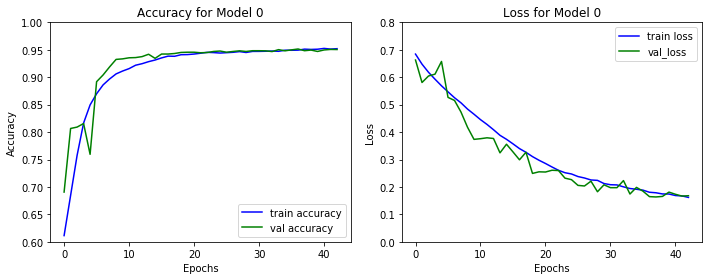

In [48]:
plot_accuracy_loss('Model 0', model0, (.6,1), (0,.8))

In [51]:
y_train_pred0 = model0.predict_classes(X_train, batch_size = 20455)
y_val_pred0 = model0.predict_classes(X_val, batch_size = 5114)
y_train_prob0 = model0.predict_proba(X_train, batch_size = 20455)
y_val_prob0 = model0.predict_proba(X_val, batch_size = 5114)

In [53]:
compare_classification_metrics(y_train, y_train_pred0, y_val, y_val_pred0)

{'Train Accuracy': 0.95,
 'Train Precision': 0.83,
 'Train Recall': 0.45,
 'Train F1': 0.58,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.43,
 'Validation F1': 0.55}

Adjusted Accuracy: 0.9477903793508017
Adjusted Precision: 0.6619718309859155
Adjusted Recall: 0.5236768802228412
Adjusted F1 Score: 0.5847589424572317




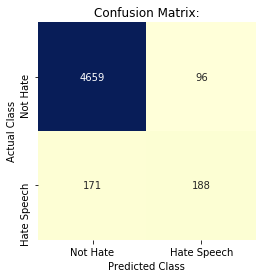

In [61]:
adj_y_val0, cm0 = adjust_threshold_and_score(y_val, y_val_prob0, .4, RNN = True)

## Model 0a: 

In [68]:
model0a = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model0a.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model0a.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model0a.add(LSTM(128, return_sequences=True))
model0a.add(BatchNormalization())

model0a.add(LSTM(128))
model0a.add(BatchNormalization())

model0a.add(Dense(1, activation='sigmoid'))

model0a.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model0a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_7 (LSTM)                (None, 39, 128)           219648    
_________________________________________________________________
batch_normalization_6 (Batch (None, 39, 128)           512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 11,690,885
Trainable params: 351,873
Non-trainable params: 11,339,012
__________________________________________________________

In [69]:
history = model0a.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 227s 11ms/step - loss: 0.6734 - acc: 0.6240 - val_loss: 0.5212 - val_acc: 0.8844
Epoch 2/200
20455/20455 [==============================] - 204s 10ms/step - loss: 0.6255 - acc: 0.7671 - val_loss: 0.5296 - val_acc: 0.8838
Epoch 3/200
20455/20455 [==============================] - 193s 9ms/step - loss: 0.5884 - acc: 0.8432 - val_loss: 0.4681 - val_acc: 0.9218
Epoch 4/200
20455/20455 [==============================] - 214s 10ms/step - loss: 0.5582 - acc: 0.8739 - val_loss: 0.5732 - val_acc: 0.8672
Epoch 5/200
20455/20455 [==============================] - 193s 9ms/step - loss: 0.5267 - acc: 0.8875 - val_loss: 0.4276 - val_acc: 0.9331
Epoch 6/200
20455/20455 [==============================] - 192s 9ms/step - loss: 0.4989 - acc: 0.9001 - val_loss: 0.3998 - val_acc: 0.9343
Epoch 7/200
20455/20455 [==============================] - 195s 10ms/step - loss: 0.4704 - acc: 0.9120 - val_loss:

In [70]:
model0a.save_weights('results/RNN/models/model0a.weights.h5', overwrite = True)
model0a.save('results/RNN/models/model0a.h5', overwrite = True)

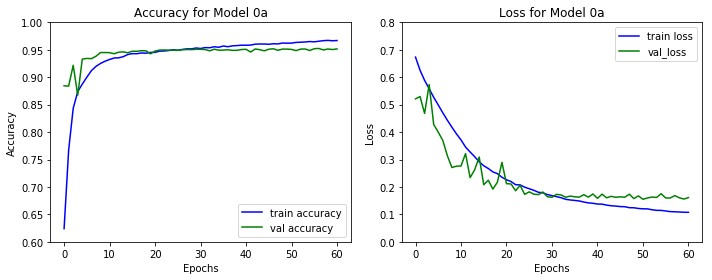

In [96]:
plot_accuracy_loss('Model 0a', model0a, (.6,1), (0,.8))

In [72]:
y_train_pred0a = model0a.predict_classes(X_train, batch_size = 20455)
y_val_pred0a = model0a.predict_classes(X_val, batch_size = 5114)
y_train_prob0a = model0a.predict_proba(X_train, batch_size = 20455)
y_val_prob0a = model0a.predict_proba(X_val, batch_size = 5114)

In [73]:
compare_classification_metrics(y_train, y_train_pred0a, y_val, y_val_pred0a)

{'Train Accuracy': 0.97,
 'Train Precision': 0.96,
 'Train Recall': 0.6,
 'Train F1': 0.74,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.45,
 'Validation F1': 0.57}

Adjusted Accuracy: 0.9507235041063746
Adjusted Precision: 0.7183673469387755
Adjusted Recall: 0.49025069637883006
Adjusted F1 Score: 0.5827814569536424




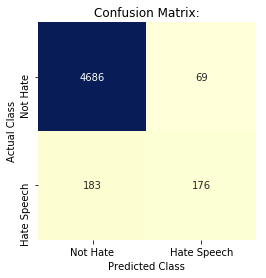

In [74]:
adj_y_val0a, cm0a = adjust_threshold_and_score(y_val, y_val_prob0a, .4, RNN = True)

### RNN 1 - no class weight adjustments

In [591]:
# init = tf.global_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init)

In [75]:
seed(10)
set_random_seed(10)

In [76]:
model1 = Sequential()

csv_logger = CSVLogger('results/RNN/history_log/model1.training.log')
# filepath = 'results/RNN/models/model1.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model1.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model1.add(LSTM(64, activation='relu', return_sequences=True))
model1.add(BatchNormalization())

model1.add(LSTM(64, activation='relu'))
model1.add(BatchNormalization())

model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy'])

print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_9 (LSTM)                (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_8 (Batch (None, 39, 64)            256       
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                12416     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 11,444,773
Trainable params: 106,081
Non-trainable params: 11,338,692
__________________________________________________________

In [77]:
history = model1.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 118s 6ms/step - loss: 0.7455 - acc: 0.4676 - val_loss: 0.7682 - val_acc: 0.7933
Epoch 2/200
20455/20455 [==============================] - 117s 6ms/step - loss: 0.7140 - acc: 0.6415 - val_loss: 0.7581 - val_acc: 0.7489
Epoch 3/200
20455/20455 [==============================] - 109s 5ms/step - loss: 0.6839 - acc: 0.7631 - val_loss: 0.7577 - val_acc: 0.8328
Epoch 4/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6539 - acc: 0.8247 - val_loss: 0.6758 - val_acc: 0.8702
Epoch 5/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6290 - acc: 0.8601 - val_loss: 0.6612 - val_acc: 0.8999
Epoch 6/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.6112 - acc: 0.8767 - val_loss: 0.5848 - val_acc: 0.9183
Epoch 7/200
20455/20455 [==============================] - 110s 5ms/step - loss: 0.5947 - acc: 0.8832 - val_loss: 0.5

In [78]:
model1.save_weights('results/RNN/models/model1.weights.h5', overwrite = True)
model1.save('results/RNN/models/model1.h5', overwrite = True)

In [134]:
model1 = load_model('results/RNN/models/model1.h5')

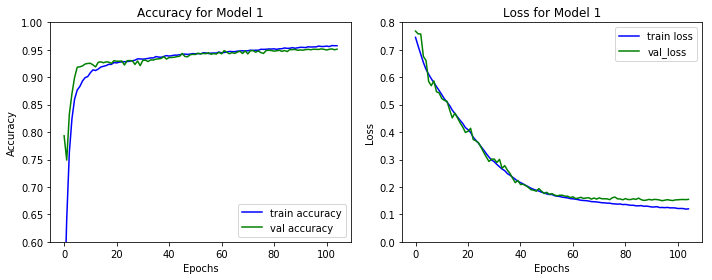

In [79]:
plot_accuracy_loss('Model 1', model1,(.6,1), (0,.8))

In [83]:
y_train_pred1 = model1.predict_classes(X_train, batch_size = 20455)
y_val_pred1 = model1.predict_classes(X_val, batch_size = 5114)
y_train_prob1 = model1.predict_proba(X_train, batch_size = 20455)
y_val_prob1 = model1.predict_proba(X_val, batch_size = 5114)

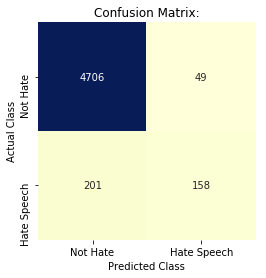

In [87]:
seaborn_confusion_matrix(y_val, y_val_pred1)

In [89]:
compare_classification_metrics(y_train, y_train_pred1, y_val, y_val_pred1)

{'Train Accuracy': 0.96,
 'Train Precision': 0.88,
 'Train Recall': 0.47,
 'Train F1': 0.61,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.76,
 'Validation Recall': 0.44,
 'Validation F1': 0.56}

In [90]:
pd.DataFrame(y_val_prob1).describe()

,0
count,5114.000000
mean,0.065470
std,0.163814
min,0.000000
25%,0.006414
50%,0.011144
75%,0.035260
max,1.000000


Adjusted Accuracy: 0.9403597966366836
Adjusted Precision: 0.5692307692307692
Adjusted Recall: 0.6183844011142061
Adjusted F1 Score: 0.5927903871829105




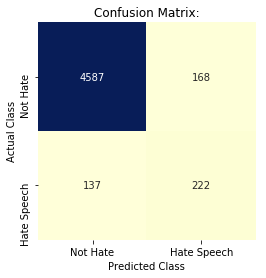

In [105]:
adj_y_val1, cm1 = adjust_threshold_and_score(y_val, y_val_prob1, .2, RNN = True)

### RNN 2 - class weights 

In [106]:
model2 = Sequential()

# filepath = 'results/RNN/weights_model2.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model2.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model2.add(LSTM(64, activation='relu', return_sequences=True))
model2.add(BatchNormalization())

model2.add(LSTM(64, activation='relu'))
model2.add(BatchNormalization())

model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_13 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_12 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [107]:
history = model2.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    class_weight=[{0:1,1:10}],
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 146s 7ms/step - loss: 1.1246 - acc: 0.3884 - val_loss: 0.6577 - val_acc: 0.7898
Epoch 2/200
20455/20455 [==============================] - 130s 6ms/step - loss: 1.0781 - acc: 0.4903 - val_loss: 0.6467 - val_acc: 0.8095
Epoch 3/200
20455/20455 [==============================] - 124s 6ms/step - loss: 1.0229 - acc: 0.5384 - val_loss: 0.6843 - val_acc: 0.4896
Epoch 4/200
20455/20455 [==============================] - 129s 6ms/step - loss: 0.9493 - acc: 0.5814 - val_loss: 0.6549 - val_acc: 0.6758
Epoch 5/200
20455/20455 [==============================] - 139s 7ms/step - loss: 0.8808 - acc: 0.6352 - val_loss: 0.6137 - val_acc: 0.7268
Epoch 6/200
20455/20455 [==============================] - 141s 7ms/step - loss: 0.8404 - acc: 0.6704 - val_loss: 0.5520 - val_acc: 0.7669
Epoch 7/200
20455/20455 [==============================] - 128s 6ms/step - loss: 0.8093 - acc: 0.7132 - val_loss: 0.5

In [138]:
model2.save('results/RNN/models/model2.h5', overwrite = True)
model2.save_weights('results/RNN//models/model2.weights.h5', overwrite = True)
# model2 = load_model('results/RNN/model2.h5')

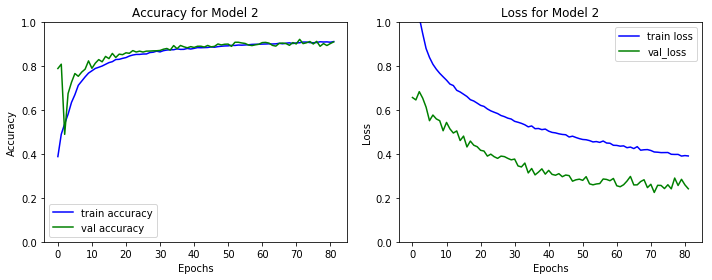

In [109]:
plot_accuracy_loss('Model 2', model2, (0, 1), (0,1))

In [110]:
y_train_pred2 = model2.predict_classes(X_train, batch_size = 20455)
y_val_pred2 = model2.predict_classes(X_val, batch_size= 5114)
y_train_prob2 = model2.predict_proba(X_train, batch_size= 20455)
y_val_prob2 = model2.predict_proba(X_val, batch_size = 5114)

In [112]:
compare_classification_metrics(y_train, y_train_pred2, y_val, y_val_pred2)

{'Train Accuracy': 0.94,
 'Train Precision': 0.53,
 'Train Recall': 0.87,
 'Train F1': 0.65,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.42,
 'Validation Recall': 0.7,
 'Validation F1': 0.53}

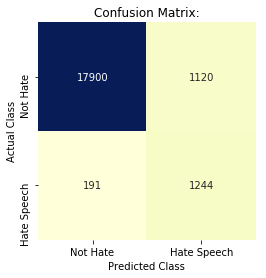

In [114]:
seaborn_confusion_matrix(y_train, y_train_pred2)

In [115]:
pd.DataFrame(y_train_prob2).describe()

,0
count,20455.000000
mean,0.169647
std,0.245092
min,0.000000
25%,0.039388
50%,0.057638
75%,0.145868
max,1.000000


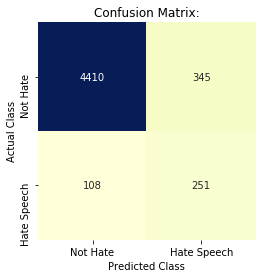

In [116]:
seaborn_confusion_matrix(y_val, y_val_pred2)

Adjusted Accuracy: 0.943097379741885
Adjusted Precision: 0.6036585365853658
Adjusted Recall: 0.5515320334261838
Adjusted F1 Score: 0.5764192139737991




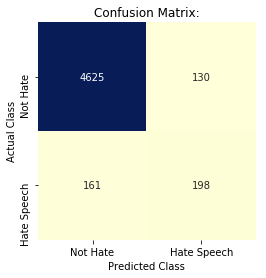

In [117]:
adj_y_val2, cm2 = adjust_threshold_and_score(y_val, y_val_prob2, .8, RNN = True)

## RNN 2b - class weights with larger batch size (100)

In [120]:
model2b = Sequential()

# filepath = 'results/RNN/weights_model2b.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 15), 
             ReduceLROnPlateau(monitor='val_loss', patience = 15)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model2b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model2b.add(LSTM(64, activation='relu', return_sequences=True))
model2b.add(BatchNormalization())

model2b.add(LSTM(64, activation='relu'))
model2b.add(BatchNormalization())

model2b.add(Dense(1, activation='sigmoid'))

model2b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model2b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 39, 300)           11338500  
_________________________________________________________________
lstm_15 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_14 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [121]:
history = model2b.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0:1,1:10}],
                    validation_data=(X_val, y_val))

Train on 20455 samples, validate on 5114 samples
Epoch 1/200
20455/20455 [==============================] - 112s 5ms/step - loss: 1.3424 - acc: 0.4873 - val_loss: 0.7417 - val_acc: 0.1406
Epoch 2/200
20455/20455 [==============================] - 93s 5ms/step - loss: 1.2722 - acc: 0.5322 - val_loss: 0.7426 - val_acc: 0.1343
Epoch 3/200
20455/20455 [==============================] - 86s 4ms/step - loss: 1.2321 - acc: 0.5446 - val_loss: 0.7261 - val_acc: 0.1592
Epoch 4/200
20455/20455 [==============================] - 89s 4ms/step - loss: 1.1872 - acc: 0.5550 - val_loss: 0.7281 - val_acc: 0.1570
Epoch 5/200
20455/20455 [==============================] - 98s 5ms/step - loss: 1.1565 - acc: 0.5589 - val_loss: 0.7324 - val_acc: 0.1641
Epoch 6/200
20455/20455 [==============================] - 81s 4ms/step - loss: 1.1443 - acc: 0.5552 - val_loss: 0.7426 - val_acc: 0.1662
Epoch 7/200
20455/20455 [==============================] - 86s 4ms/step - loss: 1.1286 - acc: 0.5389 - val_loss: 0.7411 - 

Epoch 118/200
20455/20455 [==============================] - 88s 4ms/step - loss: 0.7832 - acc: 0.7518 - val_loss: 0.5766 - val_acc: 0.7587
Epoch 119/200
20455/20455 [==============================] - 87s 4ms/step - loss: 0.7785 - acc: 0.7524 - val_loss: 0.5684 - val_acc: 0.7695
Epoch 120/200
20455/20455 [==============================] - 79s 4ms/step - loss: 0.7783 - acc: 0.7522 - val_loss: 0.5692 - val_acc: 0.7710
Epoch 121/200
20455/20455 [==============================] - 85s 4ms/step - loss: 0.7742 - acc: 0.7581 - val_loss: 0.5659 - val_acc: 0.7763
Epoch 122/200
20455/20455 [==============================] - 86s 4ms/step - loss: 0.7716 - acc: 0.7549 - val_loss: 0.5537 - val_acc: 0.7867
Epoch 123/200
20455/20455 [==============================] - 80s 4ms/step - loss: 0.7736 - acc: 0.7597 - val_loss: 0.5647 - val_acc: 0.7761
Epoch 124/200
20455/20455 [==============================] - 84s 4ms/step - loss: 0.7717 - acc: 0.7555 - val_loss: 0.5636 - val_acc: 0.7734
Epoch 125/200
20455/

In [140]:
model2b.save ('results/RNN/models/model2b.h5', overwrite = True)
model2b.save_weights ('results/RNN/models/model2b.weights.h5', overwrite = True)
# model2b = load_model('results/RNN/models/model2b.h5')

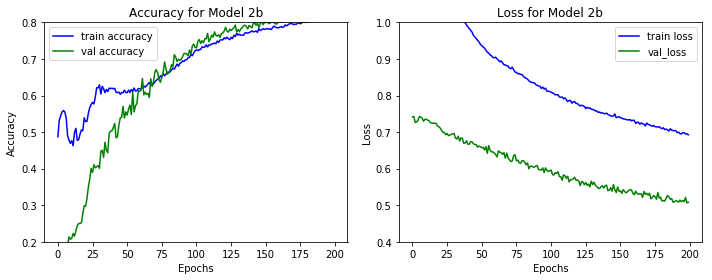

In [124]:
plot_accuracy_loss('Model 2b', model2b, (.2, .8), (.4, 1))

In [126]:
y_train_pred2b = model2b.predict_classes(X_train, batch_size = 20455)
y_val_pred2b = model2b.predict_classes(X_val, batch_size = 5144)
y_train_prob2b = model2b.predict_proba(X_train, batch_size = 20455)
y_val_prob2b = model2b.predict_proba(X_val, batch_size = 5114)

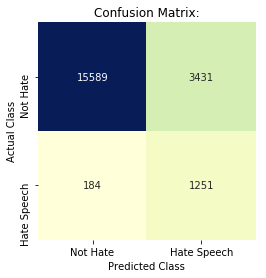

In [127]:
seaborn_confusion_matrix(y_train, y_train_pred2b)

In [128]:
pd.DataFrame(y_train_prob2b).describe()

,0
count,20455.000000
mean,0.389875
std,0.207147
min,0.000000
25%,0.243242
50%,0.324086
75%,0.478435
max,1.000000


In [130]:
compare_classification_metrics(y_train, y_train_pred2b, y_val, y_val_pred2b)

{'Train Accuracy': 0.82,
 'Train Precision': 0.27,
 'Train Recall': 0.87,
 'Train F1': 0.41,
 'Validation Accuracy': 0.82,
 'Validation Precision': 0.26,
 'Validation Recall': 0.87,
 'Validation F1': 0.4}

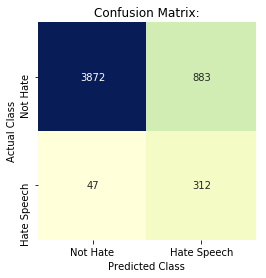

In [131]:
seaborn_confusion_matrix(y_val, y_val_pred2b)

Adjusted Accuracy: 0.932733672272194
Adjusted Precision: 0.5203252032520326
Adjusted Recall: 0.5348189415041783
Adjusted F1 Score: 0.5274725274725275




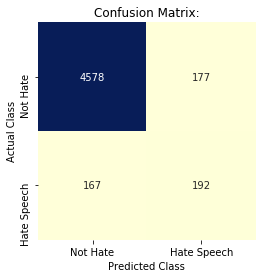

In [132]:
adj_y_val2b, cm2b = adjust_threshold_and_score(y_val, y_val_prob2b, .8, RNN = True)

# RNN 3 - upsampling # 1 - lr .000001, patience 10

In [144]:
X_train_up, y_train_up = upsample_training_data(X_train, y_train)

In [145]:
model3 = Sequential()

# filepath = 'results/RNN/models/model3_weights.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3.add(LSTM(64, activation='relu', return_sequences=True))
model3.add(BatchNormalization())

model3.add(LSTM(64, activation='relu'))
model3.add(BatchNormalization())

model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_19 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_18 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [146]:
history = model3.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 299s 8ms/step - loss: 0.6594 - acc: 0.6314 - val_loss: 0.6993 - val_acc: 0.5645
Epoch 2/200
38040/38040 [==============================] - 252s 7ms/step - loss: 0.6398 - acc: 0.6571 - val_loss: 0.6778 - val_acc: 0.7104
Epoch 3/200
38040/38040 [==============================] - 262s 7ms/step - loss: 0.6220 - acc: 0.6872 - val_loss: 0.6586 - val_acc: 0.7894
Epoch 4/200
38040/38040 [==============================] - 284s 7ms/step - loss: 0.6039 - acc: 0.7146 - val_loss: 0.6538 - val_acc: 0.7765
Epoch 5/200
38040/38040 [==============================] - 271s 7ms/step - loss: 0.5828 - acc: 0.7392 - val_loss: 0.6336 - val_acc: 0.7814
Epoch 6/200
38040/38040 [==============================] - 255s 7ms/step - loss: 0.5597 - acc: 0.7571 - val_loss: 0.5990 - val_acc: 0.8088
Epoch 7/200
38040/38040 [==============================] - 251s 7ms/step - loss: 0.5350 - acc: 0.7703 - val_loss: 0.5

In [147]:
model3.save('results/RNN/models/model3.h5', overwrite = True)
model3.save_weights('results/RNN/models/model3.weights.h5', overwrite = True)
# model3 = load_model('results/RNN/models/model3_300.h5')

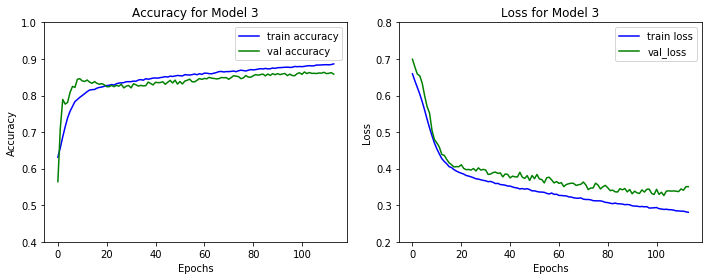

In [249]:
plot_accuracy_loss('Model 3', model3, (.4, 1), (.2, .8))

In [149]:
y_train_pred3 = model3.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3 = model3.predict_classes(X_val, batch_size = 5114)
y_train_prob3 = model3.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3 = model3.predict_proba(X_val, batch_size = 5114)

In [150]:
pd.DataFrame(y_train_prob3).describe()

,0
count,38040.000000
mean,0.504782
std,0.389341
min,0.000000
25%,0.067581
50%,0.551679
75%,0.908788
max,1.000000


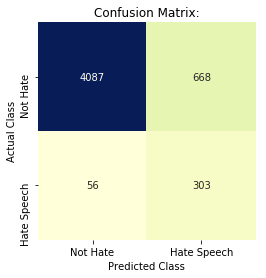

In [152]:
seaborn_confusion_matrix(y_val, y_val_pred3)

In [153]:
compare_classification_metrics(y_train_up, y_train_pred3, y_val, y_val_pred3)

{'Train Accuracy': 0.89,
 'Train Precision': 0.88,
 'Train Recall': 0.91,
 'Train F1': 0.89,
 'Validation Accuracy': 0.86,
 'Validation Precision': 0.31,
 'Validation Recall': 0.84,
 'Validation F1': 0.46}

Adjusted Accuracy: 0.9278451310129058
Adjusted Precision: 0.4894957983193277
Adjusted Recall: 0.649025069637883
Adjusted F1 Score: 0.5580838323353292




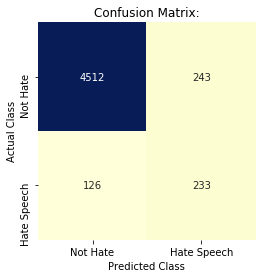

In [154]:
y_adj_val3, cm3 = adjust_threshold_and_score (y_val, y_val_prob3, .8, RNN = True)

## RNN 3b - Upsampling   
increased learning rate to .0001 before, which increased adj F1 to .58... now decreasing again.

Decreased learning rate to .00001-->  decreased adjusted F1 to .51

Now increasing learning rate to .001  --> reduced F1 to .42 

(lr=.0001) and batch size 100 -->. adj F1 is .57 -- maybe reduce batch size again?  

 ---> reduced batch size to 50 and got F1 of .58, but graph is all straight lines.... try reducing learning rate again to .00001?  --> curved lines, but reduced F1 to .47 by doing this
 
 now trying to add dropout - add two dropout layers of .01, and got adjusted F1 to .55
 
 now trying to increase dropout to .2

In [155]:
model3b = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3b.add(LSTM(64, activation='relu', return_sequences=True))
model3b.add(BatchNormalization())
model3b.add(Dropout(.2))

model3b.add(LSTM(64, activation='relu'))
model3b.add(BatchNormalization())
model3b.add(Dropout(.2))

model3b.add(Dense(1, activation='sigmoid'))

model3b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) 

print(model3b.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_21 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_20 (Batc (None, 39, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
___________________________

In [156]:
history = model3b.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 341s 9ms/step - loss: 0.4468 - acc: 0.7858 - val_loss: 0.3630 - val_acc: 0.8479
Epoch 2/200
38040/38040 [==============================] - 257s 7ms/step - loss: 0.3503 - acc: 0.8524 - val_loss: 0.3595 - val_acc: 0.8352
Epoch 3/200
38040/38040 [==============================] - 264s 7ms/step - loss: 0.3052 - acc: 0.8739 - val_loss: 0.3112 - val_acc: 0.8784
Epoch 4/200
38040/38040 [==============================] - 256s 7ms/step - loss: 0.2722 - acc: 0.8878 - val_loss: 0.3284 - val_acc: 0.8510
Epoch 5/200
38040/38040 [==============================] - 257s 7ms/step - loss: 0.2509 - acc: 0.9005 - val_loss: 0.2538 - val_acc: 0.8936
Epoch 6/200
38040/38040 [==============================] - 255s 7ms/step - loss: 0.2409 - acc: 0.9064 - val_loss: 0.3507 - val_acc: 0.8442
Epoch 7/200
38040/38040 [==============================] - 253s 7ms/step - loss: 0.2411 - acc: 0.9049 - val_loss: 0.3

In [157]:
model3b.save('results/RNN/models/model3b.h5', overwrite = True)
model3b.save_weights('results/RNN/models/model3b.weights.h5', overwrite = True)
# model3b = load_model('results/RNN/models/model3b.h5')

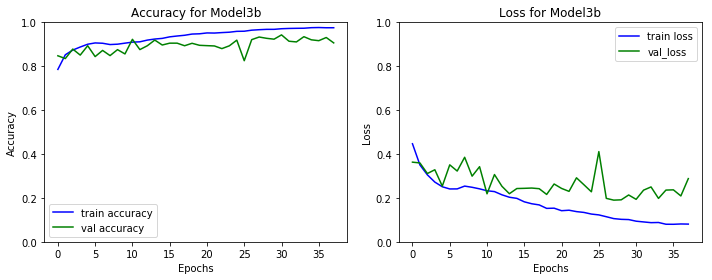

In [158]:
plot_accuracy_loss ('Model3b', model3b, (0,1), (0,1))

In [159]:
y_train_pred3b = model3b.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3b = model3b.predict_classes(X_val, batch_size = 5114)
y_train_prob3b = model3b.predict_proba(X_train_up, batch_size = 5114)
y_val_prob3b = model3b.predict_proba(X_val, batch_size = 38040)

In [160]:
pd.DataFrame(y_train_prob3b).describe()

,0
count,38040.000000
mean,0.514009
std,0.477402
min,0.000000
25%,0.003928
50%,0.901771
75%,0.980069
max,1.000000


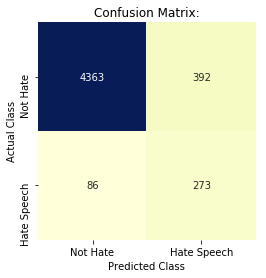

In [162]:
seaborn_confusion_matrix(y_val, y_val_pred3b)

In [163]:
compare_classification_metrics(y_train_up, y_train_pred3b, y_val, y_val_pred3b)

{'Train Accuracy': 0.98,
 'Train Precision': 0.95,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.41,
 'Validation Recall': 0.76,
 'Validation F1': 0.53}

Adjusted Accuracy: 0.9225655064528745
Adjusted Precision: 0.466786355475763
Adjusted Recall: 0.724233983286908
Adjusted F1 Score: 0.5676855895196506




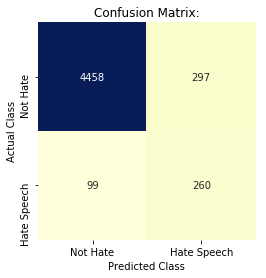

In [164]:
y_adj_val3b, cm3b = adjust_threshold_and_score(y_val, y_val_prob3b, .8, RNN = True)

## RNN 3c - upsampling - removing dropout

In [166]:
model3c = Sequential()

# filepath = 'results/RNN/weights_3c.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c.add(LSTM(64, activation='relu', return_sequences=True))
model3c.add(BatchNormalization())

model3c.add(LSTM(64, activation='relu'))
model3c.add(BatchNormalization())

model3c.add(Dense(1, activation='sigmoid'))

model3c.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) #optimizer=Adam

print(model3c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_23 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_22 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [167]:
history = model3c.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/200
38040/38040 [==============================] - 316s 8ms/step - loss: 0.4111 - acc: 0.8128 - val_loss: 0.3496 - val_acc: 0.8481
Epoch 2/200
38040/38040 [==============================] - 286s 8ms/step - loss: 0.3003 - acc: 0.8754 - val_loss: 0.2994 - val_acc: 0.8887
Epoch 3/200
38040/38040 [==============================] - 279s 7ms/step - loss: 0.2476 - acc: 0.9021 - val_loss: 0.3965 - val_acc: 0.8283
Epoch 4/200
38040/38040 [==============================] - 282s 7ms/step - loss: 0.2000 - acc: 0.9252 - val_loss: 0.1809 - val_acc: 0.9345
Epoch 5/200
38040/38040 [==============================] - 7726s 203ms/step - loss: 0.1670 - acc: 0.9400 - val_loss: 0.3994 - val_acc: 0.8387
Epoch 6/200
38040/38040 [==============================] - 328s 9ms/step - loss: 0.1377 - acc: 0.9537 - val_loss: 0.2566 - val_acc: 0.9126
Epoch 7/200
38040/38040 [==============================] - 300s 8ms/step - loss: 0.1164 - acc: 0.9626 - val_loss: 

In [168]:
model3c.save('results/RNN/models/model3c.h5', overwrite = True)
model3c.save_weights('results/RNN/models/model3c.weights.h5', overwrite = True)
# model3 = load_model('results/RNN/models/model3c.h5')

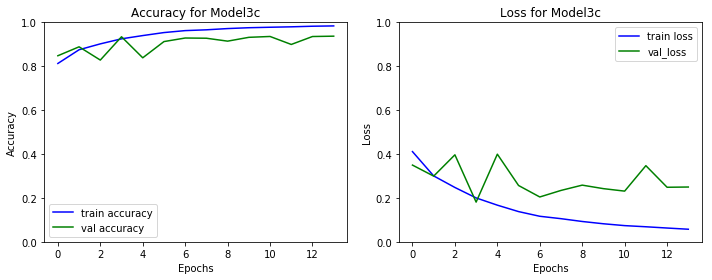

In [188]:
plot_accuracy_loss ('Model3c', model3c, (0,1), (0,1))

In [170]:
y_train_pred3c = model3c.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c = model3c.predict_classes(X_val, batch_size = 5114)
y_train_prob3c = model3c.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c = model3c.predict_proba(X_val, batch_size = 5114)

In [171]:
pd.DataFrame(y_train_pred3c).describe()

,0
count,38040.000000
mean,0.501919
std,0.500003
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [174]:
compare_classification_metrics(y_train_up, y_train_pred3c, y_val, y_val_pred3c)

{'Train Accuracy': 0.99,
 'Train Precision': 0.99,
 'Train Recall': 0.99,
 'Train F1': 0.99,
 'Validation Accuracy': 0.94,
 'Validation Precision': 0.55,
 'Validation Recall': 0.62,
 'Validation F1': 0.58}

Adjusted Accuracy: 0.9372311302307391
Adjusted Precision: 0.5467980295566502
Adjusted Recall: 0.6183844011142061
Adjusted F1 Score: 0.580392156862745




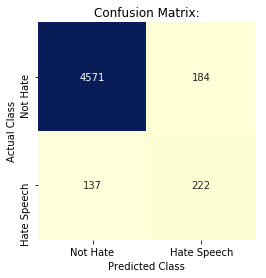

In [185]:
y_adj_val3c, cm3c = adjust_threshold_and_score(y_val, y_val_pred3c, .001, RNN = True)

## RNN 3c2c - upsampling with increased patience, epochs and lower learning rate

In [226]:
model3c2c = Sequential()

# filepath = 'results/RNN/weights_3c2c.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2c.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2c.add(LSTM(64, activation='relu', return_sequences=True))
model3c2c.add(BatchNormalization())

model3c2c.add(LSTM(64, activation='relu'))
model3c2c.add(BatchNormalization())

model3c2c.add(Dense(1, activation='sigmoid'))

model3c2c.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model3c2c.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_36 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_35 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_37 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_36 (Batc (None, 64)                256       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [227]:
history = model3c2c.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 259s 7ms/step - loss: 0.6697 - acc: 0.6157 - val_loss: 0.6976 - val_acc: 0.5624
Epoch 2/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.4842 - acc: 0.7832 - val_loss: 0.4969 - val_acc: 0.7673
Epoch 3/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.3915 - acc: 0.8254 - val_loss: 0.3985 - val_acc: 0.8224
Epoch 4/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.3634 - acc: 0.8406 - val_loss: 0.3644 - val_acc: 0.8412
Epoch 5/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3479 - acc: 0.8511 - val_loss: 0.3937 - val_acc: 0.8219
Epoch 6/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3365 - acc: 0.8560 - val_loss: 0.4000 - val_acc: 0.8156
Epoch 7/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.3272 - acc: 0.8620 - val_loss: 0.3

38040/38040 [==============================] - 214s 6ms/step - loss: 0.0847 - acc: 0.9755 - val_loss: 0.2416 - val_acc: 0.9265
Epoch 60/250
38040/38040 [==============================] - 213s 6ms/step - loss: 0.0795 - acc: 0.9771 - val_loss: 0.2582 - val_acc: 0.9247
Epoch 61/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0789 - acc: 0.9770 - val_loss: 0.2518 - val_acc: 0.9237
Epoch 62/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.0770 - acc: 0.9781 - val_loss: 0.2460 - val_acc: 0.9284
Epoch 63/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0765 - acc: 0.9780 - val_loss: 0.2542 - val_acc: 0.9273
Epoch 64/250
38040/38040 [==============================] - 214s 6ms/step - loss: 0.0742 - acc: 0.9787 - val_loss: 0.2773 - val_acc: 0.9185
Epoch 65/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.0718 - acc: 0.9797 - val_loss: 0.2676 - val_acc: 0.9183
Epoch 66/250
38040/38040 [=======

In [228]:
model3c2c.save('results/RNN/models/model3c2c.h5', overwrite = True)
model3c2c.save_weights('results/RNN/models/model3c2c.weights.h5', overwrite = True)
# model3c2c = load_model('results/RNN/models/model3c2c.h5')

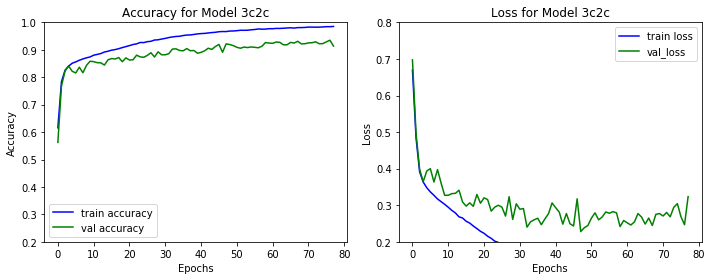

In [229]:
plot_accuracy_loss('Model 3c2c', model3c2c, (.2, 1), ((.2, .8)))

In [230]:
y_train_pred3c2c= model3c2c.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2c= model3c2c.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2c = model3c2c.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2c = model3c2c.predict_proba(X_val, batch_size = 5114)

In [231]:
compare_classification_metrics(y_train_up, y_train_pred3c2c, y_val, y_val_pred3c2c)

{'Train Accuracy': 0.98,
 'Train Precision': 0.97,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.43,
 'Validation Recall': 0.7,
 'Validation F1': 0.53}

Adjusted Accuracy: 0.9309737974188502
Adjusted Precision: 0.5065217391304347
Adjusted Recall: 0.649025069637883
Adjusted F1 Score: 0.5689865689865689




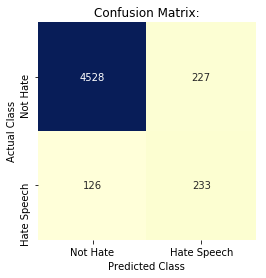

In [232]:
adj3c2c, cm3c2c = adjust_threshold_and_score(y_val, y_val_prob3c2c, .9, RNN = True)

## RNN 3c2b - upsampling with increased patience, dropout .01

In [219]:
model3c2b = Sequential()

# filepath = 'results/RNN/models/weights_3c2b.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2b.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2b.add(LSTM(64, activation='relu', return_sequences=True))
model3c2b.add(BatchNormalization())
model3c2b.add(Dropout(.01))

model3c2b.add(LSTM(64, activation='relu'))
model3c2b.add(BatchNormalization())
model3c2b.add(Dropout(.01))

model3c2b.add(Dense(1, activation='sigmoid'))

model3c2b.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) #optimizer=Adam

print(model3c2b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_34 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_33 (Batc (None, 39, 64)            256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_34 (Batc (None, 64)                256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
__________

In [220]:
history = model3c2b.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 332s 9ms/step - loss: 0.6869 - acc: 0.5688 - val_loss: 0.7314 - val_acc: 0.2147
Epoch 2/250
38040/38040 [==============================] - 285s 7ms/step - loss: 0.6031 - acc: 0.6916 - val_loss: 0.6217 - val_acc: 0.6871
Epoch 3/250
38040/38040 [==============================] - 287s 8ms/step - loss: 0.4611 - acc: 0.7921 - val_loss: 0.4283 - val_acc: 0.8005
Epoch 4/250
38040/38040 [==============================] - 283s 7ms/step - loss: 0.4043 - acc: 0.8160 - val_loss: 0.4086 - val_acc: 0.8043
Epoch 5/250
38040/38040 [==============================] - 280s 7ms/step - loss: 0.3821 - acc: 0.8276 - val_loss: 0.4202 - val_acc: 0.8021
Epoch 6/250
38040/38040 [==============================] - 279s 7ms/step - loss: 0.3668 - acc: 0.8356 - val_loss: 0.3782 - val_acc: 0.8285
Epoch 7/250
38040/38040 [==============================] - 279s 7ms/step - loss: 0.3581 - acc: 0.8426 - val_loss: 0.3

38040/38040 [==============================] - 224s 6ms/step - loss: 0.1025 - acc: 0.9691 - val_loss: 0.2481 - val_acc: 0.9226
Epoch 60/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0993 - acc: 0.9702 - val_loss: 0.2699 - val_acc: 0.9181
Epoch 61/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0986 - acc: 0.9709 - val_loss: 0.2784 - val_acc: 0.9181
Epoch 62/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0968 - acc: 0.9704 - val_loss: 0.2840 - val_acc: 0.9165
Epoch 63/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0914 - acc: 0.9734 - val_loss: 0.2809 - val_acc: 0.9185
Epoch 64/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0931 - acc: 0.9723 - val_loss: 0.2774 - val_acc: 0.9187
Epoch 65/250
38040/38040 [==============================] - 224s 6ms/step - loss: 0.0905 - acc: 0.9733 - val_loss: 0.2839 - val_acc: 0.9214
Epoch 66/250
38040/38040 [=======

In [221]:
model3c2b.save('results/RNN/models/model3c2b.h5', overwrite = True)
model3c2b.save_weights('results/RNN/models/model3c2b_weights.h5', overwrite = True)
# model3c2b = model.load('results/RNN/models/model3c2b.h5')

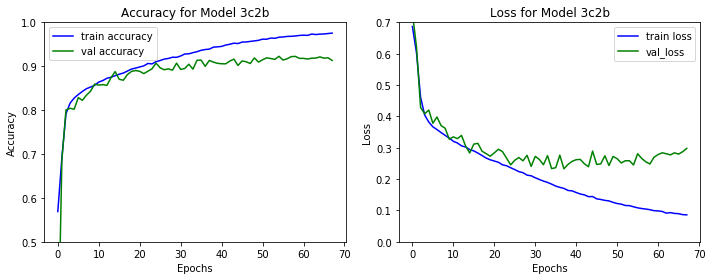

In [222]:
plot_accuracy_loss('Model 3c2b', model3c2b, (.5, 1), (0,.7))

In [223]:
y_train_pred3c2b = model3c2b.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2b = model3c2b.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2b = model3c2b.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2b = model3c2b.predict_proba(X_val, batch_size = 5114)

In [224]:
compare_classification_metrics(y_train_up, y_train_pred3c2b, y_val, y_val_pred3c2b)

{'Train Accuracy': 0.98,
 'Train Precision': 0.96,
 'Train Recall': 1.0,
 'Train F1': 0.98,
 'Validation Accuracy': 0.91,
 'Validation Precision': 0.43,
 'Validation Recall': 0.73,
 'Validation F1': 0.54}

Adjusted Accuracy: 0.9350801720766523
Adjusted Precision: 0.5306122448979592
Adjusted Recall: 0.6518105849582173
Adjusted F1 Score: 0.5850000000000001




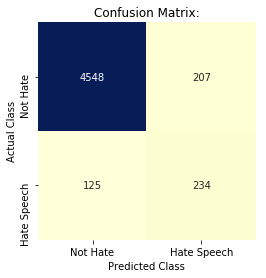

In [225]:
adj3c2b, cm3c2b = adjust_threshold_and_score(y_val, y_val_prob3c2b, .9, RNN = True)

## RNN 3c2 - with patience 30

In [233]:
model3c2 = Sequential()

# filepath = 'results/RNN/weights_3c2.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30)]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3c2.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3c2.add(LSTM(64, activation='relu', return_sequences=True))
model3c2.add(BatchNormalization())

model3c2.add(LSTM(64, activation='relu'))
model3c2.add(BatchNormalization())

model3c2.add(Dense(1, activation='sigmoid'))

model3c2.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy']) #optimizer=Adam

print(model3c2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_38 (LSTM)               (None, 39, 64)            93440     
_________________________________________________________________
batch_normalization_37 (Batc (None, 39, 64)            256       
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
batch_normalization_38 (Batc (None, 64)                256       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 11,465,541
Trainable params: 126,785
Non-trainable params: 11,338,756
__________________________________________________________

In [234]:
history = model3c2.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 252s 7ms/step - loss: 0.7030 - acc: 0.5036 - val_loss: 0.7184 - val_acc: 0.2337
Epoch 2/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6901 - acc: 0.5491 - val_loss: 0.7201 - val_acc: 0.3019
Epoch 3/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.6809 - acc: 0.5987 - val_loss: 0.7016 - val_acc: 0.4333
Epoch 4/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6705 - acc: 0.6245 - val_loss: 0.6861 - val_acc: 0.6905
Epoch 5/250
38040/38040 [==============================] - 216s 6ms/step - loss: 0.6606 - acc: 0.6520 - val_loss: 0.6777 - val_acc: 0.6259
Epoch 6/250
38040/38040 [==============================] - 215s 6ms/step - loss: 0.6474 - acc: 0.6808 - val_loss: 0.6823 - val_acc: 0.5209
Epoch 7/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.6321 - acc: 0.7107 - val_loss: 0.6

38040/38040 [==============================] - 489s 13ms/step - loss: 0.3318 - acc: 0.8584 - val_loss: 0.3714 - val_acc: 0.8355
Epoch 60/250
38040/38040 [==============================] - 540s 14ms/step - loss: 0.3284 - acc: 0.8594 - val_loss: 0.3751 - val_acc: 0.8324
Epoch 61/250
38040/38040 [==============================] - 396s 10ms/step - loss: 0.3259 - acc: 0.8625 - val_loss: 0.3749 - val_acc: 0.8311
Epoch 62/250
38040/38040 [==============================] - 410s 11ms/step - loss: 0.3249 - acc: 0.8615 - val_loss: 0.3763 - val_acc: 0.8342
Epoch 63/250
38040/38040 [==============================] - 301s 8ms/step - loss: 0.3265 - acc: 0.8615 - val_loss: 0.3757 - val_acc: 0.8340
Epoch 64/250
38040/38040 [==============================] - 832s 22ms/step - loss: 0.3257 - acc: 0.8608 - val_loss: 0.3693 - val_acc: 0.8377
Epoch 65/250
38040/38040 [==============================] - 312s 8ms/step - loss: 0.3234 - acc: 0.8639 - val_loss: 0.3693 - val_acc: 0.8379
Epoch 66/250
38040/38040 [==

38040/38040 [==============================] - 270s 7ms/step - loss: 0.2789 - acc: 0.8858 - val_loss: 0.3510 - val_acc: 0.8553
Epoch 118/250
38040/38040 [==============================] - 261s 7ms/step - loss: 0.2747 - acc: 0.8890 - val_loss: 0.3579 - val_acc: 0.8535
Epoch 119/250
38040/38040 [==============================] - 281s 7ms/step - loss: 0.2741 - acc: 0.8898 - val_loss: 0.3463 - val_acc: 0.8580
Epoch 120/250
38040/38040 [==============================] - 242s 6ms/step - loss: 0.2729 - acc: 0.8913 - val_loss: 0.3482 - val_acc: 0.8571
Epoch 121/250
38040/38040 [==============================] - 238s 6ms/step - loss: 0.2711 - acc: 0.8915 - val_loss: 0.3381 - val_acc: 0.8619
Epoch 122/250
38040/38040 [==============================] - 240s 6ms/step - loss: 0.2730 - acc: 0.8908 - val_loss: 0.3375 - val_acc: 0.8580
Epoch 123/250
38040/38040 [==============================] - 238s 6ms/step - loss: 0.2726 - acc: 0.8900 - val_loss: 0.3304 - val_acc: 0.8629
Epoch 124/250
38040/38040 [

38040/38040 [==============================] - 228s 6ms/step - loss: 0.2334 - acc: 0.9091 - val_loss: 0.3014 - val_acc: 0.8735
Epoch 176/250
38040/38040 [==============================] - 229s 6ms/step - loss: 0.2338 - acc: 0.9102 - val_loss: 0.3071 - val_acc: 0.8721
Epoch 177/250
38040/38040 [==============================] - 228s 6ms/step - loss: 0.2345 - acc: 0.9098 - val_loss: 0.3018 - val_acc: 0.8735
Epoch 178/250
38040/38040 [==============================] - 239s 6ms/step - loss: 0.2327 - acc: 0.9105 - val_loss: 0.3005 - val_acc: 0.8754
Epoch 179/250
38040/38040 [==============================] - 228s 6ms/step - loss: 0.2305 - acc: 0.9103 - val_loss: 0.3095 - val_acc: 0.8723
Epoch 180/250
38040/38040 [==============================] - 230s 6ms/step - loss: 0.2322 - acc: 0.9105 - val_loss: 0.3142 - val_acc: 0.8727
Epoch 181/250
38040/38040 [==============================] - 229s 6ms/step - loss: 0.2301 - acc: 0.9112 - val_loss: 0.3116 - val_acc: 0.8731
Epoch 182/250
38040/38040 [

38040/38040 [==============================] - 224s 6ms/step - loss: 0.1971 - acc: 0.9294 - val_loss: 0.2844 - val_acc: 0.8838
Epoch 234/250
38040/38040 [==============================] - 223s 6ms/step - loss: 0.1968 - acc: 0.9282 - val_loss: 0.2885 - val_acc: 0.8842
Epoch 235/250
38040/38040 [==============================] - 227s 6ms/step - loss: 0.1978 - acc: 0.9289 - val_loss: 0.2813 - val_acc: 0.8854
Epoch 236/250
38040/38040 [==============================] - 220s 6ms/step - loss: 0.1984 - acc: 0.9280 - val_loss: 0.2923 - val_acc: 0.8850
Epoch 237/250
38040/38040 [==============================] - 222s 6ms/step - loss: 0.1967 - acc: 0.9273 - val_loss: 0.2838 - val_acc: 0.8870
Epoch 238/250
38040/38040 [==============================] - 219s 6ms/step - loss: 0.1949 - acc: 0.9299 - val_loss: 0.2895 - val_acc: 0.8815
Epoch 239/250
38040/38040 [==============================] - 233s 6ms/step - loss: 0.1961 - acc: 0.9286 - val_loss: 0.2988 - val_acc: 0.8815
Epoch 240/250
38040/38040 [

In [235]:
model3c2.save('results/RNN/models/model3c2.h5')
model3c2.save_weights('results/RNN/models/model3c2.weights.h5')
# model3c2b = model.load('results/RNN/models/model3c2.h5')

In [236]:
y_train_pred3c2 = model3c2.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3c2 = model3c2.predict_classes(X_val, batch_size = 5114)
y_train_prob3c2 = model3c2.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3c2 = model3c2.predict_proba(X_val, batch_size = 5114)

In [237]:
compare_classification_metrics(y_train_up, y_train_pred3c2, y_val, y_val_pred3c2)

{'Train Accuracy': 0.94,
 'Train Precision': 0.91,
 'Train Recall': 0.97,
 'Train F1': 0.94,
 'Validation Accuracy': 0.89,
 'Validation Precision': 0.36,
 'Validation Recall': 0.79,
 'Validation F1': 0.49}

Adjusted Accuracy: 0.9380132968322252
Adjusted Precision: 0.5596590909090909
Adjusted Recall: 0.5487465181058496
Adjusted F1 Score: 0.5541490857946555




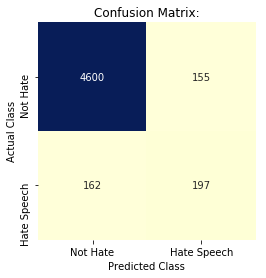

In [238]:
adj3c2, cm3c2 = adjust_threshold_and_score(y_val, y_val_prob3c2,.9, RNN = True)

## RNN 3d - upsampling;  using 3c parameters + Adam optimizer

In [ ]:
model3d = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3d.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
            csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3d.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model3d.add(LSTM(64, activation='relu', return_sequences=True))
model3d.add(BatchNormalization())

model3d.add(LSTM(64, activation='relu'))
model3d.add(BatchNormalization())

model3d.add(Dense(1, activation='sigmoid'))

model3d.compile(loss='binary_crossentropy', optimizer = Adam(lr=.00001), metrics=['accuracy'])

print(model3d.summary())

In [ ]:
history = model3d.fit(X_train_up, 
                    y_train_up,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

In [ ]:
model3d.save('results/RNN/models/model3d.h5', overwrite = True)
model3d.save_weights('results/RNN/models/model3d.weights.h5', overwrite = True)
# model3d = model.load('results/RNN/models/model3d.h5')

In [ ]:
plot_accuracy_loss('Model 3d', model3d, (.6,1), (0,.8))

In [ ]:
y_train_pred3d = model3d.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3d = model3d.predict_classes(X_val, batch_size = 5114)
y_train_prob3d = model3d.predict_proba(X_train_up, batch_size = 38040)
y_val_prob3d = model3d.predict_proba(X_val, batch_size = 5114)

In [ ]:
adj3d, cm3d = adjust_threshold_and_score(y_val, y_val_prob3d, .9, RNN = True)

In [ ]:
pd.DataFrame(y_train_prob3d).describe()

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred3d)

In [ ]:
compare_classification_metrics(y_train_up, y_train_pred3d, y_val, y_val_pred3d)

In [ ]:
y_adj_val3d, cm3d = adjust_threshold_and_score(y_val, y_val_prob3d, .84, RNN = True)

## RNN 3f - upsampling - reducing to one layer LSTM 

In [256]:
model3f = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3f.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3f.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

# model3f.add(LSTM(64, activation='relu', return_sequences=True))
# model3f.add(BatchNormalization())

model3f.add(LSTM(64, activation='relu'))
model3f.add(BatchNormalization())

model3f.add(Dense(1, activation='sigmoid'))

model3f.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.0001), metrics=['accuracy']) #optimizer=Adam

print(model3f.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_43 (LSTM)               (None, 64)                93440     
_________________________________________________________________
batch_normalization_42 (Batc (None, 64)                256       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 11,432,261
Trainable params: 93,633
Non-trainable params: 11,338,628
_________________________________________________________________
None


In [257]:
history = model3f.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=50,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 152s 4ms/step - loss: 0.4459 - acc: 0.8034 - val_loss: 0.3745 - val_acc: 0.8348
Epoch 2/250
38040/38040 [==============================] - 133s 4ms/step - loss: 0.3179 - acc: 0.8732 - val_loss: 0.2846 - val_acc: 0.8889
Epoch 3/250
38040/38040 [==============================] - 134s 4ms/step - loss: 0.2820 - acc: 0.8893 - val_loss: 0.4841 - val_acc: 0.7732
Epoch 4/250
38040/38040 [==============================] - 125s 3ms/step - loss: 0.2594 - acc: 0.9007 - val_loss: 0.3569 - val_acc: 0.8725
Epoch 5/250
38040/38040 [==============================] - 126s 3ms/step - loss: 0.2455 - acc: 0.9094 - val_loss: 0.3900 - val_acc: 0.8567
Epoch 6/250
38040/38040 [==============================] - 128s 3ms/step - loss: 0.2291 - acc: 0.9171 - val_loss: 0.2625 - val_acc: 0.9378
Epoch 7/250
38040/38040 [==============================] - 127s 3ms/step - loss: 0.2224 - acc: 0.9218 - val_loss: 0.2

In [258]:
model3f.save('results/RNN/models/model3f.h5')
model3f.save_weights('results/RNN/models/model3f.weights.h5')
# model3f = model.load('results/RNN/models/model3f.h5')

In [ ]:
plot_accuracy_loss('Model 3f', model3f, (.6,1), (0,.8))

In [ ]:
y_train_pred3f = model3f.predict_classes(X_train_up, batch_size = 50)
y_val_pred3f = model3f.predict_classes(X_val, batch_size = 50)
y_train_prob3f = model3f.predict_proba(X_train_up, batch_size = 50)
y_val_prob3f = model3f.predict_proba(X_val, batch_size = 50)

In [727]:
pd.DataFrame(y_train_prob3f).describe()

,0
count,38040.000000
mean,0.406776
std,0.327530
min,0.000000
25%,0.079190
50%,0.363966
75%,0.731913
max,0.999998


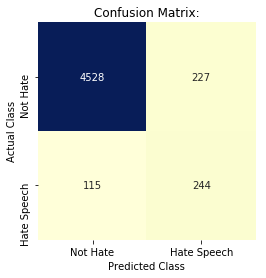

In [729]:
seaborn_confusion_matrix(y_val, y_val_pred3f)

In [730]:
compare_classification_metrics(y_train_up, y_train_pred3f, y_val, y_val_pred3f)

{'Train Accuracy': 0.91,
 'Train Precision': 0.96,
 'Train Recall': 0.86,
 'Train F1': 0.91,
 'Validation Accuracy': 0.93,
 'Validation Precision': 0.52,
 'Validation Recall': 0.68,
 'Validation F1': 0.59}

Adjusted Accuracy: 0.9489636292530309
Adjusted Precision: 0.6737588652482269
Adjusted Recall: 0.5292479108635098
Adjusted F1 Score: 0.5928237129485179




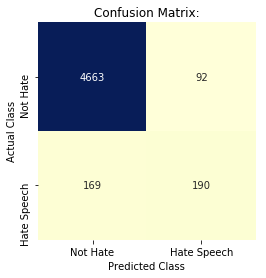

In [731]:
y_adj_val3f, cm3f = adjust_threshold_and_score(y_val, y_val_prob3f, .7, RNN = True)

## RNN 3g - upsampling with just 1 layer, increasing batch size to 100

-- got F1 up to .6 without adjustment (adjustment didn't increase F1).  Now trying to decrease learning rate to .00001 again to see if it helps, since the validation loss and accuracy were volatile

In [ ]:
model3g = Sequential()

# filepath = 'results/RNN/weights.best.hdf5'
csv_logger = CSVLogger('results/RNN/history_log/model3g.training.log')

callbacks = [EarlyStopping(monitor='val_loss', patience = 30), 
             ReduceLROnPlateau(monitor='val_loss', patience = 30),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model3g.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

# model3f.add(LSTM(64, activation='relu', return_sequences=True))
# model3f.add(BatchNormalization())

model3g.add(LSTM(64, activation='relu'))
model3g.add(BatchNormalization())

model3g.add(Dense(1, activation='sigmoid'))

model3g.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.00001), metrics=['accuracy']) 

print(model3g.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 39, 300)           11338500  
_________________________________________________________________
lstm_44 (LSTM)               (None, 64)                93440     
_________________________________________________________________
batch_normalization_43 (Batc (None, 64)                256       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 11,432,261
Trainable params: 93,633
Non-trainable params: 11,338,628
_________________________________________________________________
None


In [ ]:
history = model3g.fit(X_train_up, 
                    y_train_up,
                    epochs=250,
                    batch_size=100,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

Train on 38040 samples, validate on 5114 samples
Epoch 1/250
38040/38040 [==============================] - 93s 2ms/step - loss: 0.6911 - acc: 0.6428 - val_loss: 0.6811 - val_acc: 0.8490
Epoch 2/250
38040/38040 [==============================] - 76s 2ms/step - loss: 0.6813 - acc: 0.7195 - val_loss: 0.6524 - val_acc: 0.8645
Epoch 3/250
38040/38040 [==============================] - 76s 2ms/step - loss: 0.6431 - acc: 0.7808 - val_loss: 0.5782 - val_acc: 0.8541
Epoch 4/250
38040/38040 [==============================] - 78s 2ms/step - loss: 0.5530 - acc: 0.8095 - val_loss: 0.5352 - val_acc: 0.8002
Epoch 5/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.4815 - acc: 0.8215 - val_loss: 0.5137 - val_acc: 0.7806
Epoch 6/250
38040/38040 [==============================] - 74s 2ms/step - loss: 0.4394 - acc: 0.8300 - val_loss: 0.4444 - val_acc: 0.8076
Epoch 7/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.4111 - acc: 0.8371 - val_loss: 0.4190 - v

38040/38040 [==============================] - 69s 2ms/step - loss: 0.1851 - acc: 0.9440 - val_loss: 0.2369 - val_acc: 0.9091
Epoch 60/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1824 - acc: 0.9450 - val_loss: 0.2038 - val_acc: 0.9251
Epoch 61/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1814 - acc: 0.9457 - val_loss: 0.2197 - val_acc: 0.9126
Epoch 62/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1785 - acc: 0.9468 - val_loss: 0.2717 - val_acc: 0.8864
Epoch 63/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1769 - acc: 0.9481 - val_loss: 0.2042 - val_acc: 0.9224
Epoch 64/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1758 - acc: 0.9487 - val_loss: 0.2820 - val_acc: 0.8837
Epoch 65/250
38040/38040 [==============================] - 69s 2ms/step - loss: 0.1732 - acc: 0.9502 - val_loss: 0.2622 - val_acc: 0.8919
Epoch 66/250
38040/38040 [==============

Epoch 118/250
38040/38040 [==============================] - 71s 2ms/step - loss: 0.1222 - acc: 0.9720 - val_loss: 0.1941 - val_acc: 0.9321
Epoch 119/250
38040/38040 [==============================] - 70s 2ms/step - loss: 0.1197 - acc: 0.9725 - val_loss: 0.1890 - val_acc: 0.9339
Epoch 120/250
38040/38040 [==============================] - 70s 2ms/step - loss: 0.1201 - acc: 0.9723 - val_loss: 0.2172 - val_acc: 0.9202
Epoch 121/250
38040/38040 [==============================] - 75s 2ms/step - loss: 0.1189 - acc: 0.9730 - val_loss: 0.2045 - val_acc: 0.9286
Epoch 122/250
38040/38040 [==============================] - 73s 2ms/step - loss: 0.1183 - acc: 0.9728 - val_loss: 0.2179 - val_acc: 0.9216
Epoch 123/250
38040/38040 [==============================] - 72s 2ms/step - loss: 0.1181 - acc: 0.9730 - val_loss: 0.2143 - val_acc: 0.9253
Epoch 124/250
38040/38040 [==============================] - 74s 2ms/step - loss: 0.1174 - acc: 0.9731 - val_loss: 0.2207 - val_acc: 0.9224
Epoch 125/250
38040/

In [ ]:
model3g.save('results/RNN/models/model3g.h5')
model3g.save_weights('results/RNN/models/model3g.weights.h5')
# model3g = model.load('results/RNN/models/model3g.h5')

In [ ]:
plot_accuracy_loss('Model 3g', model3g, (.6,1), (0,.8))

In [ ]:
y_train_pred3g = model3g.predict_classes(X_train_up, batch_size = 38040)
y_val_pred3g = model3g.predict_classes(X_val, batch_size = 5114)
y_train_prob3g = model3g.predict_proba(X_train_up, batch_size = 38040
y_val_prob3g = model3g.predict_proba(X_val, batch_size = 5114)

In [ ]:
pd.DataFrame(y_train_prob3g).describe()

In [ ]:
seaborn_confusion_matrix(y_train_up, y_train_pred3g)

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred3g)

In [ ]:
compare_classification_metrics(y_train_up, y_train_pred3g, y_val, y_val_pred3g)

In [ ]:
y_adj_val3g, cm3g = adjust_threshold_and_score(y_val, y_val_prob3g, .8, RNN = True)

## RNN 4 - class weight balanced

In [ ]:
model4 = Sequential()

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

csv_logger = CSVLogger('results/RNN/history_log/model4.training.log')

# filepath = 'results/RNN/weights_model4.best.hdf5'

callbacks = [EarlyStopping(monitor='val_loss', patience = 10), 
             ReduceLROnPlateau(monitor='val_loss', patience = 10),
             csv_logger]
#              ModelCheckpoint(filepath, save_best_only = True, save_weights_only = True)]

model4.add(Embedding(num_words, 300, weights=[embedding_matrix300], input_length= 39, trainable=False))

model4.add(LSTM(64, activation='relu', return_sequences=True))
model4.add(BatchNormalization())

model4.add(LSTM(64, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer = rmsprop(lr=.000001), metrics=['accuracy'])

print(model4.summary())

In [ ]:
history = model4.fit(X_train, 
                    y_train,
                    epochs=200,
                    batch_size=50,
                    callbacks=callbacks,
                    class_weight=class_weights,
                    validation_data=(X_val, y_val))

In [ ]:
model4.save('results/RNN/models/model4.h5', overwrite = True)
model4.save_weights('results/RNN/models/model4.weights.h5', overwrite = True)
# model4 = model.load('results/RNN/models/model4.h5')

In [ ]:
plot_accuracy_loss('Model 4', model4, (.6,1), (0,.8))

In [ ]:
y_train_pred4 = model4.predict_classes(X_train, batch_size = 20455)
y_val_pred4 = model4.predict_classes(X_val, batch_size = 5114)
y_train_prob4 = model4.predict_proba(X_train, batch_size = 20455)
y_val_prob4 = model4.predict_proba(X_val, batch_size = 5114)

In [ ]:
pd.DataFrame(y_train_prob4).describe()

In [ ]:
seaborn_confusion_matrix(y_val, y_val_pred4)

In [ ]:
y_adj_val4, cm4 = adjust_threshold_and_score(y_val, y_val_prob4, .8, RNN = True)

# Building Word 2 Vec Models 

### 100 Dimension Model 

In [25]:
from time import time
t = time()

RNN_w2v_model = gensim.models.Word2Vec(X_token_list, sg=1, min_count=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.13 mins


In [26]:
RNN_w2v_model.build_vocab

<bound method BaseWordEmbeddingsModel.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x1a3ea3d940>>

In [27]:
RNN_w2v_model.train(X_token_list, total_examples=RNN_w2v_model.corpus_count, epochs=RNN_w2v_model.epochs)

(1650113, 1980385)

In [28]:
RNN_w2v_model.save('data/RNN_w2v.model')

In [29]:
RNN_w2v_model = gensim.models.Word2Vec.load('data/RNN_w2v.model')

### 300 Dimension Model 

In [27]:
RNN_w2vmodel300 = gensim.models.Word2Vec(X_token_list, sg=1, min_count=1, size = 300)

In [28]:
RNN_w2vmodel300.build_vocab

<bound method BaseWordEmbeddingsModel.build_vocab of <gensim.models.word2vec.Word2Vec object at 0x10a8472b0>>

In [29]:
RNN_w2vmodel300.train(X_token_list, total_examples=RNN_w2vmodel300.corpus_count, 
                   epochs=RNN_w2vmodel300.epochs)

(1650650, 1980385)

In [30]:
RNN_w2vmodel300.save('data/RNN_w2v300.model')

In [31]:
RNN_w2vmodel300 = gensim.models.Word2Vec.load('data/RNN_w2v300.model')

In [35]:
num_words = 37795
EMBEDDING_DIM = 300
embedding_matrix300 = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    print(word, i)
    if word in RNN_w2vmodel300.wv.vocab:
        embedding_matrix300[i] = RNN_w2vmodel300.wv.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix300, axis=1) == 0))

the 1
to 2
i 3
a 4
you 5
and 6
in 7
for 8
of 9
is 10
my 11
it 12
s 13
love 14
this 15
on 16
with 17
be 18
t 19
day 20
that 21
all 22
so 23
are 24
me 25
amp 26
happy 27
your 28
at 29
have 30
we 31
am 32
can 33
just 34
will 35
when 36
not 37
do 38
u 39
what 40
life 41
like 42
time 43
m 44
but 45
today 46
from 47
up 48
now 49
new 50
thankful 51
out 52
as 53
positive 54
get 55
was 56
people 57
about 58
how 59
our 60
bihday 61
good 62
by 63
no 64
they 65
one 66
see 67
more 68
smile 69
if 70
don 71
go 72
who 73
want 74
father 75
he 76
take 77
work 78
healthy 79
re 80
fun 81
weekend 82
an 83
summer 84
has 85
there 86
or 87
make 88
family 89
got 90
us 91
days 92
friday 93
best 94
here 95
great 96
his 97
way 98
need 99
friends 100
beautiful 101
why 102
bull 103
only 104
going 105
first 106
really 107
their 108
wait 109
morning 110
music 111
world 112
back 113
ur 114
tomorrow 115
week 116
know 117
some 118
been 119
very 120
cute 121
sad 122
orlando 123
fathersday 124
never 125
her 126
think 127


south 1270
cut 1271
de 1272
foodporn 1273
works 1274
above 1275
lyrics 1276
collection 1277
anime 1278
bro 1279
reasons 1280
tour 1281
bar 1282
entire 1283
deal 1284
euros 1285
product 1286
ignorance 1287
kitty 1288
english 1289
religion 1290
near 1291
plan 1292
songs 1293
flagday 1294
em 1295
ugh 1296
ireland 1297
passion 1298
eating 1299
worry 1300
creative 1301
muslims 1302
turned 1303
idwp 1304
lets 1305
key 1306
begin 1307
straight 1308
gamedev 1309
texas 1310
ma 1311
animal 1312
ya 1313
land 1314
bored 1315
between 1316
definitely 1317
sadly 1318
allow 1319
front 1320
losing 1321
apparently 1322
lie 1323
colombia 1324
shootings 1325
yum 1326
europe 1327
taken 1328
match 1329
project 1330
schools 1331
faces 1332
lack 1333
powerful 1334
calgary 1335
filled 1336
stress 1337
bigot 1338
user 1339
humpday 1340
natural 1341
heaven 1342
brilliant 1343
stream 1344
lebron 1345
played 1346
watched 1347
thats 1348
spent 1349
shi 1350
ripchristinagrimmie 1351
round 1352
greatest 1353
speech 1

friendly 2013
teach 2014
eid 2015
recipe 2016
filter 2017
famous 2018
basis 2019
heat 2020
holy 2021
lazy 2022
sis 2023
altright 2024
products 2025
packed 2026
international 2027
fucked 2028
beard 2029
laws 2030
raining 2031
keshi 2032
desperate 2033
toronto 2034
marketing 2035
haters 2036
horrific 2037
eu 2038
electronic 2039
enteainment 2040
basketball 2041
sundayfunday 2042
madrid 2043
views 2044
treats 2045
facts 2046
ng 2047
breaks 2048
murdered 2049
delighted 2050
ad 2051
ali 2052
movement 2053
yolo 2054
affected 2055
twice 2056
fr 2057
animation 2058
brighton 2059
figure 2060
snap 2061
mall 2062
shocking 2063
carl 2064
period 2065
player 2066
statement 2067
voters 2068
inspire 2069
vsco 2070
parenting 2071
fox 2072
poster 2073
confidence 2074
angel 2075
nowplaying 2076
bloggers 2077
creating 2078
caturday 2079
ends 2080
network 2081
roses 2082
ashamed 2083
kills 2084
crew 2085
precious 2086
knowledge 2087
wa 2088
crap 2089
george 2090
upcoming 2091
confident 2092
chick 2093
lit 

melbourne 2749
newcastle 2750
instagay 2751
paul 2752
policy 2753
victory 2754
nowadays 2755
rejected 2756
hates 2757
pissed 2758
swing 2759
among 2760
rate 2761
losangeles 2762
meme 2763
possibility 2764
bullying 2765
terms 2766
bbuk 2767
quiz 2768
achieve 2769
stopped 2770
babygirl 2771
director 2772
responsible 2773
enjoyed 2774
grind 2775
bullshit 2776
swear 2777
skies 2778
laptop 2779
loveisland 2780
fantasy 2781
whoop 2782
victim 2783
horse 2784
unless 2785
comingsoon 2786
changing 2787
selfish 2788
sunglasses 2789
suppos 2790
runs 2791
prom 2792
roof 2793
falling 2794
wwe 2795
rant 2796
jewish 2797
discrimination 2798
officers 2799
bond 2800
jimmy 2801
factsguide 2802
systemic 2803
skills 2804
suicidal 2805
kicking 2806
aists 2807
push 2808
yup 2809
former 2810
bee 2811
windows 2812
edit 2813
announced 2814
polarisation 2815
uselections 2816
higher 2817
vendor 2818
example 2819
camera 2820
degree 2821
bound 2822
cried 2823
aldub 2824
illegal 2825
superhero 2826
cop 2827
wembley 

seven 3450
pants 3451
tennis 3452
sites 3453
democrats 3454
army 3455
information 3456
butt 3457
infinite 3458
rough 3459
instasize 3460
unforgettable 3461
nra 3462
newlook 3463
sukhbir 3464
theconjuring 3465
frog 3466
flip 3467
loneliness 3468
manga 3469
breathe 3470
battlefield 3471
datenight 3472
hs 3473
hall 3474
negativity 3475
raghuramrajan 3476
glastonbury 3477
murdering 3478
lows 3479
oprah 3480
aim 3481
masters 3482
abrahamhicks 3483
wimbledon 3484
musicvideo 3485
contact 3486
desse 3487
dating 3488
preview 3489
retro 3490
motorcycle 3491
gemini 3492
sake 3493
lineup 3494
dates 3495
majesty 3496
weren 3497
charging 3498
disgraceful 3499
arkansas 3500
reviews 3501
broadway 3502
blamed 3503
guide 3504
honey 3505
billy 3506
nike 3507
repostapp 3508
helps 3509
racists 3510
guncontrol 3511
flow 3512
chain 3513
fred 3514
granted 3515
guilty 3516
grief 3517
kept 3518
abc 3519
saturdays 3520
primary 3521
editing 3522
moto 3523
sneezy 3524
bashful 3525
caring 3526
fuckin 3527
brithday 

reverse 4124
removed 4125
motivational 4126
heabreak 4127
onelove 4128
genuinely 4129
miscegenation 4130
treatment 4131
lay 4132
discuss 4133
ole 4134
momma 4135
meanwhile 4136
panda 4137
uae 4138
spoke 4139
hong 4140
jive 4141
jivemap 4142
soooo 4143
grab 4144
aw 4145
connection 4146
circle 4147
square 4148
selfietime 4149
taiwan 4150
disabled 4151
travels 4152
cruise 4153
inequality 4154
bonus 4155
tyler 4156
suddenly 4157
catsoftwitter 4158
standard 4159
hulk 4160
corner 4161
montreal 4162
olathe 4163
pt 4164
dancers 4165
lily 4166
kanye 4167
stella 4168
troubles 4169
tries 4170
lightroom 4171
probe 4172
companies 4173
venezuela 4174
fails 4175
jocoxmp 4176
glamorous 4177
iftar 4178
server 4179
cape 4180
cpi 4181
consider 4182
discount 4183
ancient 4184
emma 4185
jus 4186
speechless 4187
curb 4188
israeli 4189
spoilers 4190
triste 4191
inked 4192
academy 4193
wash 4194
km 4195
glow 4196
casino 4197
baba 4198
mods 4199
mug 4200
vijay 4201
fingerscrossed 4202
aware 4203
goodtime 4204


pressure 5485
integrity 5486
honesty 5487
extends 5488
attacking 5489
battles 5490
expats 5491
steve 5492
spreading 5493
eatclean 5494
blowjob 5495
crystals 5496
measures 5497
bridetobe 5498
attract 5499
gunman 5500
udta 5501
defend 5502
lb 5503
fallen 5504
alot 5505
selfharm 5506
happend 5507
hitting 5508
arrest 5509
instalove 5510
autumn 5511
spaces 5512
smallthings 5513
floridashooting 5514
holly 5515
options 5516
ankara 5517
sandwich 5518
dipped 5519
trumpsamerica 5520
presented 5521
oitnbchat 5522
experienced 5523
residents 5524
minorities 5525
myworld 5526
vietnam 5527
familiar 5528
stereotype 5529
protesters 5530
caer 5531
impressed 5532
sixty 5533
mill 5534
thesis 5535
bots 5536
icymi 5537
hongkong 5538
wcw 5539
vocal 5540
hsp 5541
victorious 5542
carlos 5543
nicola 5544
lions 5545
deciding 5546
trained 5547
prospect 5548
sailing 5549
crude 5550
embarrassing 5551
ableism 5552
committee 5553
core 5554
despise 5555
causes 5556
ella 5557
dump 5558
stood 5559
seasonal 5560
disorder

stephcurry 6239
indiegame 6240
sneaks 6241
alps 6242
cotd 6243
dhoni 6244
gunna 6245
verse 6246
mar 6247
sample 6248
covers 6249
suppose 6250
freemilo 6251
egg 6252
travelled 6253
occur 6254
aspect 6255
tubbytoons 6256
hahahaha 6257
grounded 6258
penguin 6259
yorkshire 6260
rewards 6261
si 6262
woods 6263
ua 6264
kylielipkit 6265
vape 6266
frarou 6267
welfare 6268
ounce 6269
loo 6270
damien 6271
yayyyy 6272
grandad 6273
renaissance 6274
mf 6275
felling 6276
barney 6277
normalizing 6278
commentary 6279
copaamerica 6280
businesses 6281
bhagwantmann 6282
ghuggi 6283
producers 6284
spy 6285
mourning 6286
apaments 6287
knees 6288
facing 6289
fighters 6290
lands 6291
inbox 6292
homeless 6293
micropoetry 6294
bdayspl 6295
powers 6296
norman 6297
rus 6298
arabs 6299
mania 6300
electro 6301
queue 6302
supreme 6303
priority 6304
achieved 6305
pals 6306
pirates 6307
godisgood 6308
ocd 6309
skill 6310
ontario 6311
papi 6312
simplest 6313
twisted 6314
straw 6315
greeting 6316
rebellion 6317
welsh 6

focusing 7141
cod 7142
somerset 7143
shipped 7144
solved 7145
calories 7146
prague 7147
freak 7148
rhythm 7149
linkedin 7150
patient 7151
condemn 7152
harmonious 7153
threw 7154
maialas 7155
supernatural 7156
eaten 7157
perceived 7158
acquired 7159
cupcakes 7160
equipment 7161
impo 7162
thoughtful 7163
acknowledge 7164
instaday 7165
pe 7166
fucks 7167
rejection 7168
donor 7169
lite 7170
foodblogger 7171
jehovah 7172
thugs 7173
bigly 7174
syndrome 7175
graders 7176
ta 7177
recall 7178
tops 7179
ro 7180
yah 7181
bigender 7182
darkknight 7183
objective 7184
gettingfitter 7185
phoenix 7186
graduates 7187
muna 7188
shos 7189
bullet 7190
pundits 7191
rapacious 7192
hairstyle 7193
emojis 7194
elementary 7195
glory 7196
projection 7197
cult 7198
pllseason 7199
greater 7200
thumb 7201
mubarak 7202
define 7203
homedecor 7204
unprofessional 7205
heros 7206
sundayvibes 7207
uploading 7208
lifetime 7209
aft 7210
hooray 7211
cyclists 7212
adopt 7213
justme 7214
fp 7215
hidden 7216
draghi 7217
aftr 7

counts 7807
madly 7808
rainbowrowell 7809
wright 7810
stroke 7811
addressing 7812
eastern 7813
punish 7814
waving 7815
lv 7816
organisation 7817
deadpool 7818
enroute 7819
bluntly 7820
rbnz 7821
nooo 7822
pressured 7823
skinned 7824
obesity 7825
fathersdayquotes 7826
chest 7827
ordering 7828
gon 7829
submission 7830
published 7831
ork 7832
trio 7833
weddingcountdown 7834
visitor 7835
iftaar 7836
macklemore 7837
impressions 7838
restaurants 7839
plaster 7840
mmmm 7841
rhonda 7842
laughable 7843
healess 7844
oslo 7845
aworks 7846
png 7847
manner 7848
congressional 7849
morocco 7850
involves 7851
kardashian 7852
waspi 7853
indiegogo 7854
nicely 7855
photoshop 7856
pron 7857
felony 7858
module 7859
nohate 7860
snails 7861
goody 7862
themusketeers 7863
forgive 7864
accusations 7865
tables 7866
payet 7867
asshat 7868
jungkookday 7869
tonite 7870
rewarding 7871
kareena 7872
raped 7873
migrants 7874
sharia 7875
beef 7876
downloadfestival 7877
ferrari 7878
trigger 7879
muhbt 7880
lajawab 7881
i

effects 8424
wesley 8425
whistling 8426
hymn 8427
wwii 8428
glastonburyfestival 8429
felicidade 8430
nancy 8431
customised 8432
pat 8433
scotus 8434
linstagram 8435
linzy 8436
fiestar 8437
bsb 8438
genre 8439
oskar 8440
css 8441
opps 8442
nintendoe 8443
latvia 8444
ballet 8445
zaynmalik 8446
positiveenergy 8447
highfive 8448
dub 8449
thegreatest 8450
harmful 8451
boanoite 8452
frio 8453
wingers 8454
macedonia 8455
sinks 8456
obligation 8457
republic 8458
ootdwiwtmetodayfwisfashion 8459
swagfringedayoffgoodday 8460
yard 8461
cretin 8462
federal 8463
candle 8464
fyi 8465
flex 8466
tvk 8467
disco 8468
apologize 8469
melissa 8470
addict 8471
pockets 8472
couture 8473
reset 8474
agency 8475
minsk 8476
uphill 8477
tak 8478
reform 8479
louise 8480
hay 8481
bonnaroo 8482
newadventure 8483
dancelife 8484
heights 8485
decides 8486
chanel 8487
legitimately 8488
libraries 8489
preparations 8490
melodic 8491
overloaded 8492
ramdan 8493
amjoy 8494
unmasking 8495
profiles 8496
pooch 8497
clintons 849

nm 9176
whit 9177
doublewin 9178
homicides 9179
festivals 9180
elderly 9181
inch 9182
boheme 9183
awaits 9184
piracy 9185
poole 9186
performances 9187
awwww 9188
jungkook 9189
credentials 9190
capture 9191
hotvideo 9192
eg 9193
shade 9194
xboxones 9195
beloy 9196
varying 9197
lighting 9198
wohwhile 9199
colbe 9200
jail 9201
tense 9202
notfunny 9203
remark 9204
skating 9205
bearded 9206
europeangp 9207
businessoppounity 9208
sel 9209
auntie 9210
lm 9211
sequel 9212
fearful 9213
brides 9214
crowdfunding 9215
minime 9216
uploaded 9217
racis 9218
mai 9219
fountain 9220
whore 9221
tgifridays 9222
loading 9223
toa 9224
musicislife 9225
biological 9226
din 9227
newsta 9228
admire 9229
donut 9230
erased 9231
thursdaytreat 9232
diysos 9233
blows 9234
elliot 9235
gathering 9236
schnauzer 9237
booster 9238
retailtherapy 9239
paicular 9240
bestdad 9241
correctly 9242
suckin 9243
craig 9244
waterford 9245
olympics 9246
bolt 9247
dumbest 9248
whales 9249
praising 9250
boycottdelta 9251
repetitive 92

journo 10392
versatile 10393
shamelessly 10394
tagging 10395
buddhist 10396
clearwater 10397
installed 10398
aimed 10399
bench 10400
bearish 10401
qualification 10402
functionality 10403
reminders 10404
jaan 10405
thelyvers 10406
lyversfacts 10407
greenglam 10408
volatility 10409
nomura 10410
lfff 10411
hysterical 10412
copies 10413
stalkers 10414
nolove 10415
keychain 10416
caroline 10417
rushing 10418
spiced 10419
exquisite 10420
gaystyle 10421
gaymen 10422
myfriend 10423
disana 10424
trixs 10425
pikeg 10426
follo 10427
affliction 10428
intellect 10429
twt 10430
peaceandlove 10431
streak 10432
kumbaya 10433
profession 10434
paphos 10435
ivankatrump 10436
manspreading 10437
hungary 10438
myson 10439
mik 10440
ikozosseg 10441
slowing 10442
emraan 10443
hashmi 10444
alisa 10445
goood 10446
stretching 10447
congressman 10448
vaitacacommafiasdv 10449
coeliac 10450
colombian 10451
alchemist 10452
shockingly 10453
rita 10454
hayes 10455
gravitypoisoning 10456
dangers 10457
healthcoach 10458

goodfeelings 11120
bingo 11121
ramadhankareem 11122
coffin 11123
awesom 11124
careeradvice 11125
hmv 11126
exclusives 11127
workouts 11128
chansung 11129
loveletter 11130
colts 11131
cheerleader 11132
slur 11133
slay 11134
crossfit 11135
spreadlove 11136
healthychoices 11137
directors 11138
cuomo 11139
yorkers 11140
eyeshadows 11141
rendering 11142
celie 11143
teamunderstudy 11144
guidelines 11145
pulseclub 11146
ripjocox 11147
justkeepswimming 11148
aiel 11149
executive 11150
imprint 11151
mastered 11152
crashbandicoot 11153
accomplish 11154
sobriety 11155
whiteman 11156
watered 11157
broadband 11158
instame 11159
diesel 11160
ryt 11161
endings 11162
festive 11163
zk 11164
mariott 11165
annoy 11166
whopper 11167
bpd 11168
apology 11169
balanceldn 11170
jealousy 11171
punishing 11172
webdev 11173
unborn 11174
sincerely 11175
nicer 11176
titan 11177
sunsunsun 11178
repping 11179
canaryislands 11180
felizlunes 11181
hypebeast 11182
postcards 11183
bitcoiners 11184
strategies 11185
joyful

rixos 11713
fir 11714
uruguay 11715
traits 11716
intend 11717
paddling 11718
molokai 11719
wheeling 11720
emily 11721
psu 11722
logan 11723
jax 11724
bowing 11725
suggest 11726
bekind 11727
activism 11728
tummies 11729
beyonc 11730
afghans 11731
wildly 11732
phenomenon 11733
exploiting 11734
womenmalayalam 11735
deceived 11736
lakelife 11737
morals 11738
pooltime 11739
ariana 11740
sugarcane 11741
memphis 11742
drones 11743
helsinki 11744
padded 11745
sahri 11746
specialmoments 11747
cleanliving 11748
finer 11749
prosperous 11750
myboy 11751
sweating 11752
atpeace 11753
prejudicial 11754
sentiment 11755
yarn 11756
gown 11757
tolerate 11758
mushrooms 11759
jesuschristempowerstransformation 11760
gayboys 11761
spiritualjourney 11762
pst 11763
jimrohn 11764
networkmarketing 11765
shahs 11766
nothng 11767
ire 11768
hun 11769
winterfest 11770
countingdown 11771
librarylife 11772
verbal 11773
viper 11774
imperialsm 11775
akarinselect 11776
stairway 11777
sef 11778
nowords 11779
greatloss 117

blossom 12416
sharply 12417
helix 12418
goaldigger 12419
blackjack 12420
westboro 12421
poolday 12422
bans 12423
mails 12424
underlying 12425
cny 12426
aviv 12427
tub 12428
chalkboard 12429
horselovers 12430
qatar 12431
weakdonald 12432
originalsong 12433
lancashire 12434
chas 12435
foodoftheday 12436
foodgasm 12437
peas 12438
kiki 12439
binoculars 12440
ovo 12441
sequinbow 12442
antisemites 12443
exercising 12444
soundtrainingnews 12445
calmdown 12446
rosalee 12447
addie 12448
babymonrosale 12449
nadalind 12450
poser 12451
blacknwhite 12452
sia 12453
snatch 12454
wig 12455
workingout 12456
nuke 12457
poolpay 12458
implying 12459
dud 12460
theodyssey 12461
reboot 12462
biherism 12463
gbj 12464
chooses 12465
suggested 12466
mag 12467
flyer 12468
titties 12469
writes 12470
mansoon 12471
slaver 12472
stmu 12473
stmugrad 12474
finallyhere 12475
optimists 12476
elgar 12477
nimrod 12478
sham 12479
thr 12480
association 12481
dahaq 12482
shekhwat 12483
mummybloggers 12484
newsingle 12485
mall

dprint 13086
theopen 13087
vent 13088
plead 13089
homeimprovement 13090
rambling 13091
vase 13092
lmc 13093
giveback 13094
livelovelaugh 13095
yonge 13096
infectious 13097
asos 13098
dayton 13099
iamwhoiam 13100
teared 13101
didthatreallyjusthappen 13102
toomanyemorions 13103
gc 13104
territory 13105
ayer 13106
girona 13107
gerona 13108
eathealthy 13109
bmottphoto 13110
healand 13111
jesuslovesyou 13112
transform 13113
kno 13114
bane 13115
philandocastile 13116
ja 13117
ilysm 13118
inactivity 13119
foodnetwork 13120
trials 13121
knicks 13122
defo 13123
oecd 13124
rootbeer 13125
caffine 13126
anya 13127
allison 13128
vineyards 13129
cons 13130
marrying 13131
pok 13132
datas 13133
lawmaker 13134
careerguide 13135
ahur 13136
wrist 13137
kerr 13138
southsudan 13139
firecracker 13140
overlap 13141
fashionblog 13142
photobomb 13143
scraps 13144
taffy 13145
psychopath 13146
nofear 13147
doodlerindelhi 13148
butthu 13149
corgi 13150
morro 13151
investigators 13152
crep 13153
makaveli 13154
mof

eker 13760
bloomed 13761
scarborough 13762
alfredo 13763
iseng 13764
likesforlikes 13765
adn 13766
dahvader 13767
laserena 13768
salmon 13769
natgeo 13770
wakeman 13771
lone 13772
yahoo 13773
stepped 13774
baranovas 13775
sunseasand 13776
issued 13777
condemning 13778
mg 13779
vedic 13780
harley 13781
johnxsafaris 13782
eastcapehunting 13783
sidney 13784
sussex 13785
cambtweet 13786
gigi 13787
compensated 13788
der 13789
tournaments 13790
firearms 13791
jupiter 13792
moma 13793
ellie 13794
friendshipgoals 13795
marxist 13796
propoganda 13797
cite 13798
grou 13799
youareaparenttoo 13800
economicapahied 13801
extract 13802
cookin 13803
islamicterrorism 13804
mothernature 13805
prayforamerica 13806
gottohaveit 13807
riders 13808
barbeque 13809
judgment 13810
impatient 13811
antisemtism 13812
hoarse 13813
avicii 13814
umf 13815
umfkorea 13816
blackisbeautiful 13817
ict 13818
littleman 13819
boasty 13820
tipping 13821
adidasler 13822
remiss 13823
edclasvegas 13824
concentration 13825
nextpl

plato 14436
origins 14437
focking 14438
croatian 14439
sone 14440
malawi 14441
keepsmiling 14442
pulled 14443
lololol 14444
fancydress 14445
piercing 14446
dobermaninfinity 14447
rewind 14448
sadder 14449
catfish 14450
amandanunes 14451
badges 14452
cebu 14453
envatomarket 14454
rocktheretweet 14455
cattle 14456
stepmom 14457
plse 14458
gogirl 14459
staged 14460
reduce 14461
offspring 14462
paxex 14463
fulfilling 14464
imitates 14465
resource 14466
inuit 14467
diaz 14468
scrolls 14469
chanapa 14470
unsigned 14471
ripoff 14472
negros 14473
gloucestershire 14474
soak 14475
benice 14476
allnightlong 14477
gurls 14478
aeon 14479
joel 14480
lesmiserables 14481
wilfully 14482
ilovethesecret 14483
ingredients 14484
suriya 14485
gorgeousgirl 14486
howard 14487
ahs 14488
motherhood 14489
refers 14490
gfe 14491
wwewaco 14492
deanambrose 14493
familyfunnight 14494
lpc 14495
accomplished 14496
sponsor 14497
boohoo 14498
myhermes 14499
isoladelba 14500
lovedogs 14501
beatles 14502
xs 14503
freshman

loooove 15075
nevergrowup 15076
notthatsad 15077
rockandroll 15078
monsterfest 15079
arbitrarily 15080
weeding 15081
chaussures 15082
strobe 15083
exits 15084
anka 15085
bydgoszcz 15086
taxis 15087
sfhea 15088
refle 15089
keyring 15090
errrr 15091
viva 15092
zing 15093
headwinds 15094
youjerryshkosane 15095
garysweekendbreakideas 15096
strugglings 15097
bloggingocdblogginglife 15098
regains 15099
poise 15100
bog 15101
wasteoftime 15102
funnel 15103
islostonyou 15104
nottrump 15105
dontforgetyourwaterproofs 15106
carnt 15107
baffle 15108
greatgrandmother 15109
smugglers 15110
releasethebeast 15111
jager 15112
cary 15113
vance 15114
establishing 15115
provincial 15116
ppls 15117
angering 15118
enfield 15119
natu 15120
commandment 15121
bail 15122
accommodation 15123
frightened 15124
whaaattttt 15125
postgrad 15126
looksamazing 15127
letsdoit 15128
bluewater 15129
bwmoves 15130
doyourbest 15131
andysessions 15132
easylistening 15133
hubbs 15134
htown 15135
camptrailcontinues 15136
ripgop 

goofiness 15734
socialmediamanagement 15735
innocense 15736
madec 15737
wih 15738
soyummy 15739
allmines 15740
notsharing 15741
auro 15742
sandoval 15743
depressioncure 15744
millionth 15745
ryanlewis 15746
thisunrulymessivemade 15747
tumim 15748
otha 15749
teacuptutucharm 15750
slowmovement 15751
learherbags 15752
sohyped 15753
imold 15754
injures 15755
fliing 15756
goomorning 15757
tobias 15758
pizzzza 15759
needabreakfromtoday 15760
nocuts 15761
uncut 15762
yippe 15763
dodgeball 15764
rhony 15765
informing 15766
masla 15767
bewafa 15768
jaun 15769
elia 15770
funey 15771
adnansms 15772
layers 15773
creme 15774
patissiere 15775
raspberries 15776
pastrychefs 15777
febch 15778
economicalcooking 15779
livehappy 15780
chimney 15781
rspb 15782
whyinternet 15783
hourfungoalstakecaremyself 15784
mindbodysoul 15785
comfoing 15786
positips 15787
plusfactorph 15788
cosmicflower 15789
elementalbob 15790
southafrika 15791
chefstalk 15792
cbgastronomi 15793
creditable 15794
albest 15795
actin 1579

tulku 16401
wisdoms 16402
tsemtulku 16403
youhavetobekiddingme 16404
bihdaybihdaycongratulations 16405
hydrated 16406
rcn 16407
ukrainiangirl 16408
waders 16409
okarito 16410
ronery 16411
gwyn 16412
jong 16413
springbreak 16414
trifecta 16415
perpetrated 16416
starship 16417
fulloflove 16418
sullivan 16419
api 16420
stirling 16421
orlandonightclub 16422
dunstaplesummerselfie 16423
dunstaple 16424
duranduran 16425
resisted 16426
capitulated 16427
cyrus 16428
ufohaslanded 16429
ufos 16430
paxxy 16431
alls 16432
maksandval 16433
ftmyers 16434
canitpleasebesaturdayalready 16435
andisa 16436
kidies 16437
theshihtzulife 16438
butty 16439
steiner 16440
paused 16441
shivers 16442
oer 16443
erkenschwick 16444
cappellen 16445
lowalbumdvdldhlove 16446
happinesssmile 16447
todayl 16448
smokejerky 16449
sodom 16450
gomorrah 16451
governmentassistance 16452
azzes 16453
oneandahalf 16454
contributor 16455
bestbud 16456
lacona 16457
isola 16458
density 16459
hyperdocs 16460
gafe 16461
googleclassroom 

wiltshire 17074
girlspeeing 17075
vipissy 17076
wakeuplikethis 17077
thepeel 17078
cabs 17079
rooftop 17080
chiling 17081
locomoco 17082
readyornot 17083
westindies 17084
gerihalliwell 17085
breaktime 17086
overheard 17087
gangster 17088
prankcall 17089
parrot 17090
smashing 17091
bachoichoi 17092
firstdaylatepost 17093
weareready 17094
rollingbacktheyears 17095
theresalwaysonewithagammyleg 17096
nannycramps 17097
lvff 17098
nsc 17099
shofilms 17100
womeninfilm 17101
canvases 17102
pads 17103
radicalislamicterrorist 17104
fusca 17105
fffwithjanelle 17106
liberated 17107
bilson 17108
latter 17109
counselor 17110
nevermypresident 17111
ilovehim 17112
burnet 17113
screendebut 17114
radicalized 17115
orgrim 17116
blackhand 17117
stormwind 17118
instinctively 17119
mimosas 17120
dzange 17121
byebyeosx 17122
bootyshake 17123
pantsoffdanceoff 17124
cloaking 17125
babiesmatter 17126
commandeered 17127
icecreamcone 17128
mcpc 17129
overestimate 17130
coldheaed 17131
foheplayers 17132
amherst 17

kanga 17659
backgroundaist 17660
kgtooheavytorunwiththo 17661
hadi 17662
garyhadi 17663
repug 17664
germans 17665
greatwriting 17666
anxiously 17667
russiastrawberrynaturehousefamilyloveredharvestvsconicesweetparents 17668
temporarily 17669
shacks 17670
irrefutable 17671
truism 17672
anmol 17673
yadien 17674
kwangsoo 17675
azharuddin 17676
brochures 17677
loyalist 17678
somme 17679
boyne 17680
mywork 17681
tattooing 17682
saturdayy 17683
compares 17684
nadien 17685
query 17686
rpdr 17687
rupaul 17688
actioncoach 17689
lelo 17690
fabulousfunloa 17691
mindlessviolence 17692
sml 17693
dmpeel 17694
dermcare 17695
ilovemonday 17696
traveltime 17697
russiangirl 17698
archetecture 17699
horaciohamlet 17700
shapes 17701
getconnected 17702
captive 17703
lockandkey 17704
dragonfruit 17705
bougainvilliea 17706
flyinbangkok 17707
muang 17708
mybabyboy 17709
skipton 17710
findingnemo 17711
timeforasaferamericaforall 17712
pulsevictims 17713
prayersforchristinagrimmiefamily 17714
camilaogorman 17715

letsmake 18235
beirutweloveyou 18236
swagged 18237
baiter 18238
slaveowner 18239
instatattoo 18240
demolition 18241
farewellboleyn 18242
whufc 18243
westham 18244
olympicstadium 18245
hillarydesperation 18246
victoriassecret 18247
perfectbody 18248
goglam 18249
greatfultogod 18250
beendoinggreat 18251
abhi 18252
newaccountoldfriends 18253
ringwood 18254
catsanddogs 18255
ralphlauren 18256
rawdenimtelagenova 18257
clarksoriginals 18258
ewww 18259
mafuckas 18260
blackseadancecamp 18261
borntodance 18262
motions 18263
oncologists 18264
crossfitgirls 18265
bumblebtschallenge 18266
spreadkindess 18267
giftfriday 18268
oseaaa 18269
anikka 18270
japonesas 18271
happyend 18272
concord 18273
newepisodes 18274
aldc 18275
woeisme 18276
witchktaft 18277
tribeon 18278
kerflooey 18279
keurig 18280
unconsumable 18281
vanillabeanfrap 18282
cakepop 18283
shaterirunnels 18284
farwellpay 18285
bestpaner 18286
seeyouontop 18287
kitkat 18288
wildisland 18289
blackbroadway 18290
toobeautifulforwords 18291
a

milesteller 18945
berating 18946
auspo 18947
hansen 18948
pauline 18949
sacrificing 18950
christopher 18951
acre 18952
markers 18953
amuse 18954
saddie 18955
bigcheeks 18956
smalllips 18957
exploding 18958
puffedup 18959
fills 18960
sweetness 18961
wasreallyhopingitwasgood 18962
nando 18963
jars 18964
flocking 18965
xenstrength 18966
rays 18967
croak 18968
onlymarco 18969
shoeing 18970
delusion 18971
bikram 18972
meth 18973
tobedads 18974
offences 18975
westyorkshire 18976
yorkshirelass 18977
vineyard 18978
focussed 18979
egl 18980
cmoncymru 18981
marathonradio 18982
sssssoooo 18983
coooooooooool 18984
doyle 18985
fathead 18986
indoorskydiving 18987
airkix 18988
heii 18989
binarshakilakirana 18990
thisgenerationsucks 18991
datingsucks 18992
nashvilletour 18993
nashvilleforever 18994
desks 18995
bccs 18996
showguide 18997
masterpiece 18998
bookedit 18999
monks 19000
camcar 19001
adolescent 19002
inferiority 19003
roa 19004
hierarchy 19005
stevenspielberg 19006
eternally 19007
stb 19008


hihi 19558
reductive 19559
oppounist 19560
truer 19561
trounced 19562
nack 19563
raji 19564
raychell 19565
selfdevelopmenttime 19566
betteryourself 19567
beanythingyouwanttobe 19568
frittata 19569
spiral 19570
epicurian 19571
culinaryfunbecause 19572
freunde 19573
loosened 19574
bbbh 19575
stillloose 19576
braamfontein 19577
lovemycity 19578
confus 19579
theo 19580
lolipop 19581
riseandshine 19582
itsabeautifulday 19583
reeva 19584
hearending 19585
sarman 19586
proliferation 19587
tickles 19588
bodyandsoul 19589
uninterested 19590
determining 19591
maturity 19592
bodrummarinafriends 19593
innovators 19594
unsurprising 19595
mideast 19596
enlist 19597
megaupload 19598
elbenwald 19599
whovian 19600
publicserviceannouncement 19601
inspirechange 19602
embraceyourself 19603
bedifferent 19604
babyshower 19605
excessive 19606
foaming 19607
ecmeetup 19608
bloggermeetup 19609
bajrang 19610
dal 19611
nsv 19612
slimmingworlduk 19613
orgasm 19614
sexysunday 19615
selfpic 19616
withxxx 19617
bookis

brenda 20540
palmer 20541
decluttering 20542
joemixon 20543
espn 20544
minnesotavikings 20545
sucklahoma 20546
oab 20547
aldubebfathersday 20548
readmore 20549
eatthatpussy 20550
calvinharris 20551
missiondiscoveryayrshire 20552
totall 20553
blessedthankful 20554
njoyhit 20555
hitmusicstation 20556
callum 20557
lifelongmemories 20558
magicalmoments 20559
happeningrightnow 20560
thatface 20561
wellwmn 20562
alll 20563
delectable 20564
lmfaoo 20565
ddesign 20566
wonn 20567
baseboll 20568
fakefood 20569
banassualtweapons 20570
rooftops 20571
gems 20572
floridashootings 20573
transformer 20574
coldness 20575
hdtc 20576
weariy 20577
salesmen 20578
tiina 20579
supplemental 20580
digitalrevolution 20581
fuckseaworld 20582
boycottseaworld 20583
chocolatters 20584
judi 20585
dench 20586
bronte 20587
sexier 20588
styleblogger 20589
stevenuniverse 20590
favorable 20591
chereb 20592
thruout 20593
organizedcrime 20594
chapelflow 20595
tripfamily 20596
bodyattack 20597
workinprogress 20598
lifestyle

daysofcode 21159
datamining 21160
datavisualization 21161
higherself 21162
wohoooo 21163
admint 21164
apathy 21165
alwayslookonthebrightsideoflife 21166
stressreliever 21167
cker 21168
excepted 21169
runmalawi 21170
lupton 21171
shameonhumanity 21172
sohot 21173
deleting 21174
thcousin 21175
dominicanfamily 21176
genetically 21177
maniacs 21178
hulu 21179
whynosound 21180
lupus 21181
godissoamazing 21182
bidder 21183
bexhill 21184
nospoliers 21185
cantwatchtonight 21186
farrah 21187
perezhilton 21188
cassette 21189
closes 21190
sttropez 21191
lequaisttropez 21192
irritations 21193
indisputably 21194
intrusively 21195
imitations 21196
whiners 21197
couyard 21198
kikmeplease 21199
monthscouple 21200
verylowiq 21201
laraza 21202
friendsforlife 21203
triumphs 21204
confidants 21205
bulwer 21206
lytton 21207
selflovemantras 21208
natsuxlucy 21209
animegif 21210
fury 21211
udtakejri 21212
sworn 21213
eeeeekkkkkk 21214
eviction 21215
needtix 21216
ripamodu 21217
morse 21218
lucid 21219
thaweb

aishhhhh 21778
airbnb 21779
airbnbmanagement 21780
livethere 21781
thatairbnbmoment 21782
bred 21783
maryhill 21784
springburn 21785
riasworld 21786
harricrishna 21787
loveca 21788
caels 21789
pumpkintheraccoon 21790
raccoon 21791
weeklyfluff 21792
pretended 21793
fruitbowl 21794
loner 21795
desync 21796
cutscenses 21797
likeme 21798
tdigcomms 21799
thecavernclub 21800
tourist 21801
acapella 21802
nascarpics 21803
ofa 21804
murca 21805
patriotic 21806
redwhiteblue 21807
cinnamon 21808
watford 21809
liebe 21810
gl 21811
sociopaths 21812
satanic 21813
felonies 21814
yf 21815
rachelpeaches 21816
yestoinec 21817
geh 21818
corpse 21819
kentuck 21820
purplehairdontcare 21821
sorandom 21822
downbytheseashore 21823
mornig 21824
btsm 21825
happinessindex 21826
ahhhhhh 21827
crewed 21828
thankspop 21829
pock 21830
thebestdayever 21831
destroys 21832
gentlebarn 21833
themoreyousharethemoreyouget 21834
growingfamily 21835
workit 21836
raditya 21837
kay 21838
wraps 21839
filhoespaiseras 21840
paido

jaylenosgarage 22482
mustanggtboxstersmazdaspeed 22483
catty 22484
blueleds 22485
steampunkarmor 22486
itsalive 22487
answering 22488
outofpropane 22489
pesto 22490
porkchops 22491
polling 22492
acecafelondon 22493
edibles 22494
caffiene 22495
sativa 22496
newgrounds 22497
destabilizes 22498
centuries 22499
immanuel 22500
whic 22501
fancafe 22502
dubs 22503
robinson 22504
livepass 22505
missedthegame 22506
godogs 22507
outwiththeold 22508
inwiththenew 22509
brockwellpark 22510
housemates 22511
hairbraids 22512
itsjustlife 22513
carlpalladino 22514
alphabet 22515
daisymarie 22516
shoeselfie 22517
readyfoheday 22518
thankstomyspecialsomeone 22519
julian 22520
unqualified 22521
officenarciccisticlectures 22522
embrac 22523
popefrancis 22524
catholicchurch 22525
thehighlight 22526
derrickhoh 22527
splitvipagency 22528
visitsplit 22529
visitcroatia 22530
neverious 22531
icantsleep 22532
deseret 22533
pushups 22534
kozlov 22535
fritz 22536
tiafoe 22537
remixes 22538
spira 22539
miband 22540


anas 23100
nimra 23101
farishta 23102
mawia 23103
khushal 23104
obtained 23105
striped 23106
stripedlove 23107
pan 23108
nomuraforum 23109
verify 23110
disapponted 23111
canufeelit 23112
imanyones 23113
btwnus 23114
tapped 23115
confoable 23116
videomarketing 23117
shiplife 23118
loveenjoyaridoranon 23119
mysonshine 23120
armcandy 23121
keke 23122
italians 23123
illegally 23124
takashi 23125
bihdaybihdayhopedreamfamil 23126
bikinibody 23127
makeyoustay 23128
quiltbag 23129
kingofcoaches 23130
gaysbreaktheinternet 23131
adeolu 23132
philips 23133
fq 23134
thongthursday 23135
girlsoftwitter 23136
ngot 23137
intal 23138
claas 23139
trophies 23140
lasalle 23141
waaaaahhh 23142
tubes 23143
minding 23144
wailed 23145
fassbender 23146
revs 23147
scouted 23148
bathesis 23149
toofar 23150
placemat 23151
maltingfloor 23152
sitcom 23153
techouse 23154
dishonesty 23155
slandering 23156
friendsdancekissnight 23157
youngsweet 23158
fellaindia 23159
classifying 23160
fucku 23161
farhad 23162
accessor

occasionally 23826
eyetalian 23827
atheist 23828
peiple 23829
joly 23830
editions 23831
finallybreak 23832
lidl 23833
byedenton 23834
olly 23835
goodluckrooster 23836
newmemeber 23837
drunkness 23838
monicapearl 23839
whoolo 23840
torv 23841
moodboard 23842
softgrunge 23843
ooxg 23844
elaine 23845
ateng 23846
strngshhhh 23847
survivable 23848
cockroaches 23849
persuit 23850
remai 23851
twoweeks 23852
gamemusic 23853
leanne 23854
bueniniciodesemana 23855
exelentelunes 23856
pawleased 23857
registrations 23858
stacked 23859
dancingontheceiling 23860
foreseearegreat 23861
amicizia 23862
amici 23863
founa 23864
vivogliobene 23865
freepik 23866
mustbe 23867
reince 23868
willbe 23869
leftin 23870
cannes 23871
blurred 23872
rationality 23873
izzy 23874
df 23875
indicates 23876
signings 23877
declan 23878
marries 23879
hecroro 23880
weddingvows 23881
homeday 23882
aba 23883
retailers 23884
commiting 23885
blunder 23886
guv 23887
clementine 23888
wisteria 23889
pti 23890
alexboxstadium 23891
ls

newlightcinemas 24512
bigboy 24513
happing 24514
rafi 24515
tux 24516
harristiestoarmin 24517
buurrendimitrivegas 24518
likemikehardwell 24519
gegenrechts 24520
nostrache 24521
noafd 24522
nopegida 24523
populism 24524
nonazis 24525
aufstehn 24526
maricism 24527
idealist 24528
proclaim 24529
granth 24530
sahib 24531
hayleyatwell 24532
fes 24533
aciclovir 24534
strokes 24535
moped 24536
rallyofthecorn 24537
dongiovanni 24538
rewatch 24539
arresteddevelopment 24540
foiin 24541
branlable 24542
pioneercamp 24543
girlbestfriends 24544
echeveria 24545
bloomsflowers 24546
iphonesia 24547
basilicabotanica 24548
mucky 24549
cress 24550
welsing 24551
drfranciscresswelsing 24552
bcos 24553
folkgood 24554
noway 24555
vallaa 24556
xico 24557
traded 24558
squashed 24559
yougotgot 24560
byeenglish 24561
cooped 24562
greyday 24563
englishweathersucks 24564
hawaiianstyle 24565
lylepierce 24566
galsontour 24567
wellduh 24568
kleenex 24569
wonderfulwakey 24570
stayunchained 24571
cobblers 24572
flatbush 

inthekitchen 25186
ecigs 25187
teenhealth 25188
vapers 25189
ecig 25190
sahirbhasin 25191
isha 25192
ishir 25193
iaint 25194
erinviversfergusonmusic 25195
lgbtmusicians 25196
vivekshraya 25197
daymade 25198
mwahahahaha 25199
spafrancorchamps 25200
tcrseries 25201
jcb 25202
trailn 25203
smoother 25204
reaperfamily 25205
freeways 25206
shippers 25207
complementarianism 25208
complementarian 25209
mindfully 25210
altering 25211
sodium 25212
nitrate 25213
msgrenaway 25214
imhappy 25215
silverado 25216
ocsc 25217
orlvsj 25218
knocking 25219
lovethemall 25220
begginer 25221
ilovea 25222
ilovepaint 25223
mayma 25224
unawareness 25225
englishteacher 25226
fash 25227
bigtime 25228
ineptness 25229
xtatic 25230
emerged 25231
gorgeouspieces 25232
nickel 25233
clifford 25234
ponce 25235
shopetsyuk 25236
dole 25237
vmin 25238
gleb 25239
savchenko 25240
sharna 25241
burgess 25242
singsbeautiful 25243
pirat 25244
jehna 25245
godson 25246
underbelly 25247
tafree 25248
jub 25249
phopo 25250
phoposarecom

statue 25836
presumptivenominee 25837
weareequal 25838
womendeliver 25839
hillarysoqualified 25840
disposition 25841
considerate 25842
deleteyouraaccount 25843
waitng 25844
firstanal 25845
rummors 25846
davidduchovny 25847
spices 25848
legionofboom 25849
weber 25850
eatthis 25851
longdistanceprobz 25852
greenpay 25853
selfiesaturday 25854
creditors 25855
justinh 25856
rodriguez 25857
notacloudinthesky 25858
gotchu 25859
smileonmyface 25860
billionairemag 25861
colourism 25862
whichever 25863
suffices 25864
sree 25865
narayana 25866
missin 25867
theyleftme 25868
fastaction 25869
dlx 25870
mofo 25871
youdisgustme 25872
kickrocks 25873
littleenglander 25874
sosmannheim 25875
slflmannheim 25876
secondsofsummerconce 25877
groupiee 25878
buhaycallcenteragent 25879
sykesasia 25880
benefit 25881
teamd 25882
wicca 25883
pagan 25884
pisces 25885
warehouse 25886
dishu 25887
plzzzz 25888
loveudisha 25889
blackcokwhiteass 25890
serverlife 25891
newmemories 25892
drunknights 25893
drunkgirls 25894
s

thepizzacompany 26520
myfood 26521
teddybear 26522
panamahat 26523
joblove 26524
awaken 26525
gudmorning 26526
phillppines 26527
manned 26528
waltr 26529
captions 26530
inte 26531
advocacy 26532
beaktv 26533
hwawards 26534
yoyas 26535
deming 26536
makemyevent 26537
zit 26538
beensqueezing 26539
guessing 26540
objectify 26541
tgi 26542
westbury 26543
whiter 26544
federline 26545
girlgrunge 26546
likeback 26547
loteni 26548
bandq 26549
awfulness 26550
striping 26551
missedit 26552
cleo 26553
lyftlifers 26554
sequoia 26555
mileycyrusedit 26556
closeted 26557
nuff 26558
allezbroadfield 26559
bureaucrat 26560
bonfire 26561
whowantstohelp 26562
crookedsmile 26563
goyim 26564
flowas 26565
hulahoops 26566
dragonstaff 26567
womenareamazing 26568
induoevents 26569
preferences 26570
fronting 26571
smileback 26572
vacaciones 26573
sfbayarea 26574
lasagna 26575
heasracing 26576
maddari 26577
payslip 26578
lacey 26579
productbali 26580
locker 26581
magis 26582
eeroaarnio 26583
shangrilahotel 26584
a

newblogpost 27272
jumpingjacks 27273
hporbust 27274
teamgryfindor 27275
semest 27276
gbesoke 27277
gonnabeepicmovie 27278
newmom 27279
workingmom 27280
mombreak 27281
mompreneur 27282
kilarney 27283
itzeebitz 27284
smallbizhour 27285
uksmallbiz 27286
dadbarkads 27287
longtimenosee 27288
jenny 27289
severeasthma 27290
nordtrom 27291
restock 27292
mutualrespect 27293
thereelscene 27294
clan 27295
persiancat 27296
gobehappy 27297
takecare 27298
marriottcareers 27299
ibbleobble 27300
fabtastic 27301
pissing 27302
ramadaan 27303
noshame 27304
deeps 27305
ohyeah 27306
tby 27307
cutekidsclub 27308
toybus 27309
heyyyy 27310
gwen 27311
stefani 27312
filmschool 27313
everythinghappensforareason 27314
hungerinhouston 27315
projectgraphite 27316
terming 27317
alevel 27318
gairloch 27319
wishmeluck 27320
tavi 27321
vinylscratch 27322
octaviamelody 27323
vinylmelody 27324
octaviascratch 27325
emtpy 27326
tmebn 27327
aetc 27328
diplomadoenmarketingdigital 27329
terminamos 27330
newworld 27331
littlw 

amarillo 27977
itsrarenowadays 27978
stevefrancis 27979
umd 27980
opal 27981
preaching 27982
twonitwittrumpsuppoers 27983
thwin 27984
musicbank 27985
justine 27986
readers 27987
daventry 27988
hod 27989
intercourse 27990
armpit 27991
hairly 27992
slightly 27993
vivre 27994
shells 27995
seashells 27996
stumppass 27997
barbecue 27998
mandan 27999
decir 28000
ather 28001
willmissthekids 28002
moretimeforgrandkids 28003
casualties 28004
mbb 28005
mygrind 28006
mrbaileybaby 28007
cakeboss 28008
claispgc 28009
swoon 28010
vellum 28011
gaining 28012
traction 28013
prevalent 28014
disc 28015
sarita 28016
itzel 28017
rethink 28018
winatallcosts 28019
ausvotes 28020
victimblaming 28021
chototel 28022
daysofpigpaintings 28023
jumpingforjoy 28024
cougar 28025
surname 28026
assassin 28027
shizzz 28028
tace 28029
debunk 28030
dontendkahanihamari 28031
hoom 28032
wordplay 28033
innuendo 28034
yuck 28035
burntpizza 28036
humfree 28037
foodallergy 28038
atheletes 28039
ericthomas 28040
blueeeeeeee 2804

airside 28734
curryrice 28735
airsidecafe 28736
ndigbo 28737
illustrious 28738
attachedatthehip 28739
unificationsday 28740
stern 28741
lls 28742
ripleyrader 28743
lifesetloveislandsatisfied 28744
urns 28745
ebola 28746
spawn 28747
thorn 28748
egyptian 28749
fps 28750
sahabat 28751
teman 28752
mybrother 28753
kocak 28754
nooltham 28755
eltham 28756
asylumseekers 28757
whiskeytangofoxtrot 28758
isi 28759
tinafey 28760
exoastro 28761
jetski 28762
loogabarooga 28763
pegida 28764
sogso 28765
lifeofaphotographer 28766
lovenature 28767
brakes 28768
bikenerd 28769
dignitas 28770
haroldfriday 28771
lolitafashion 28772
sweetlolita 28773
angelicpretty 28774
korilakkuma 28775
sanx 28776
tooise 28777
matestoi 28778
sensing 28779
facevaluetickets 28780
rainraincomeagain 28781
fitcamp 28782
manupmonday 28783
letssss 28784
bemore 28785
resurface 28786
babai 28787
gareki 28788
bihdaybalayya 28789
gravitationalwaves 28790
einsteinwasrightagain 28791
experimenting 28792
goatmilk 28793
myperson 28794
ili

gearheadhomes 29413
generally 29414
fetishes 29415
harmless 29416
objectification 29417
wholehea 29418
byeschool 29419
noschool 29420
frith 29421
thankyoufohemusic 29422
prayforourworld 29423
shesaidyes 29424
handlers 29425
donors 29426
adulting 29427
almostgraduated 29428
assitantmanager 29429
huntsvilleisd 29430
censors 29431
staar 29432
bazooka 29433
uncovers 29434
usaguncrimes 29435
noa 29436
southbound 29437
oft 29438
tendencies 29439
santaproject 29440
clement 29441
upsta 29442
diisgusted 29443
flt 29444
arnt 29445
goodweek 29446
babykroixontheway 29447
weslayin 29448
teetee 29449
caterpillars 29450
gasps 29451
wayward 29452
chrysalis 29453
bookreview 29454
mattruff 29455
outrageously 29456
bunting 29457
lifesfullofsurprises 29458
oxtweets 29459
catlady 29460
garfield 29461
zz 29462
motha 29463
woodford 29464
suppolocal 29465
comparison 29466
stillinit 29467
presidenttrump 29468
rename 29469
berpose 29470
meagainbeautywithaynk 29471
sameshitnewyear 29472
fundamentalism 29473
cali

mochithepug 30079
roundup 30080
tissues 30081
arr 30082
akta 30083
deo 30084
tumar 30085
onek 30086
lovelgq 30087
worldstar 30088
bil 30089
poppetmaster 30090
cowell 30091
sharrod 30092
wellingham 30093
premiership 30094
muslimpos 30095
hans 30096
hansolo 30097
leia 30098
jadeshadow 30099
inane 30100
melancholic 30101
jaggi 30102
ded 30103
rookiemistake 30104
prm 30105
kollywood 30106
americaneedsguncontrol 30107
mnms 30108
drfrankenstein 30109
handcramp 30110
caligraphy 30111
fineliners 30112
assist 30113
pandemonium 30114
dacks 30115
chasin 30116
adirondacks 30117
highpeaks 30118
scourge 30119
baroque 30120
antihumantraffickingbill 30121
victimrebabilitation 30122
censorboard 30123
netanyahou 30124
crapsac 30125
waltdisneyreso 30126
ukca 30127
fierse 30128
postivethinking 30129
ucsf 30130
powerofforgiveness 30131
kermit 30132
tails 30133
biting 30134
dogbite 30135
dogtreat 30136
baddies 30137
funnyvideos 30138
marquis 30139
focusonthegood 30140
praystoorlando 30141
knubisoft 30142
co

purposedly 30792
wakeupamericaca 30793
pictureperfect 30794
oncorporationst 30795
hackaton 30796
vigilant 30797
sweetescape 30798
travelblog 30799
homefohenextfewdays 30800
nathandrake 30801
founding 30802
wldve 30803
dicked 30804
nokia 30805
acquire 30806
realyogaselfie 30807
yogaoffthemat 30808
nomakeupselfie 30809
iah 30810
tmr 30811
supperdad 30812
nikonion 30813
nikkoreyes 30814
indiaclicks 30815
notbotherwdanymore 30816
coopting 30817
autocorrects 30818
starwarsspoiler 30819
sillyfaces 30820
longhairdontcare 30821
bcmes 30822
bful 30823
webpage 30824
medicalthriller 30825
tbstorm 30826
stormsocial 30827
rown 30828
blendedfamily 30829
theweekend 30830
guthrie 30831
interviewing 30832
extremelly 30833
lazysaturday 30834
kangol 30835
conormcgregor 30836
endlessly 30837
lovemygirls 30838
excitingtimesahead 30839
cashgoddess 30840
goodfoune 30841
championed 30842
bosas 30843
disorganised 30844
poaventura 30845
summerisnotyetover 30846
companyouting 30847
theketteringincident 30848
noa

burgos 31460
eastriding 31461
mongers 31462
loudest 31463
tearingup 31464
yyjaboriginalfest 31465
weirdcat 31466
shaimasunshine 31467
yogaretreat 31468
writin 31469
heiraten 31470
poker 31471
sektor 31472
nosurprise 31473
trumpinauguration 31474
polygamist 31475
moneyovermorals 31476
accommodations 31477
lasses 31478
shandy 31479
weymouth 31480
qe 31481
qeii 31482
someonesbihdaysomewhere 31483
raison 31484
etre 31485
jewworldorder 31486
mothersday 31487
showsomelove 31488
shud 31489
yvonne 31490
mnisi 31491
nkambule 31492
nyirenda 31493
lilymine 31494
shakeys 31495
getittogether 31496
mane 31497
theyy 31498
hollydays 31499
biasedlaw 31500
seprates 31501
wbal 31502
kuturns 31503
britishroyals 31504
stpaulslondon 31505
tattoocollection 31506
cranberry 31507
alwayssmiling 31508
amourjayda 31509
doomed 31510
revolutionist 31511
hollowing 31512
econ 31513
shell 31514
chillax 31515
pasumpahanisland 31516
beachtime 31517
beachgirl 31518
skid 31519
pmaallthetime 31520
cicis 31521
cicispizzasan

fashionquote 32149
peacefestival 32150
appletv 32151
yorkie 32152
lazer 32153
vkontakte 32154
gottarollwithittho 32155
whaaat 32156
makeamericasafeagain 32157
dogandduckshow 32158
robinwood 32159
activitiy 32160
peeker 32161
monitorlizard 32162
golazodealexis 32163
somn 32164
leeseonlife 32165
bymodels 32166
funfilled 32167
ginfilled 32168
myfavoritevideo 32169
raringtogo 32170
poelisabeth 32171
sequels 32172
sonny 32173
pod 32174
outnow 32175
hassan 32176
prop 32177
checkedtheboxtogetahead 32178
oceanclub 32179
daypay 32180
azzuri 32181
taketime 32182
consult 32183
dincwear 32184
brickingit 32185
deadlifts 32186
ser 32187
totorothedog 32188
totorothepup 32189
totoro 32190
spunky 32191
vai 32192
fuder 32193
wepresson 32194
pkn 32195
filme 32196
pornor 32197
sushirice 32198
eyesbrows 32199
intuition 32200
nausicaa 32201
anthonys 32202
qpac 32203
westendlive 32204
lesmis 32205
rainwater 32206
wuvip 32207
landrover 32208
kettled 32209
yearag 32210
motorracing 32211
dej 32212
nudies 32213


youre 32924
redsmoke 32925
twitters 32926
vanished 32927
shewasfunny 32928
redbook 32929
gother 32930
tryin 32931
chicagomed 32932
chicagopd 32933
tonyward 32934
silhouettes 32935
royce 32936
weddinginspiration 32937
fransis 32938
derelle 32939
crystalize 32940
convex 32941
consumes 32942
toomanyguns 32943
rwrunstreak 32944
discovering 32945
toni 32946
issa 32947
chive 32948
mottleyengagement 32949
tyjesus 32950
premierleague 32951
legitimate 32952
squatrack 32953
fuherst 32954
faromoncloa 32955
collide 32956
stauplife 32957
sirvuve 32958
alliance 32959
stallion 32960
waterdog 32961
dachshundoftheday 32962
whoops 32963
stainedglass 32964
underestimate 32965
summerevening 32966
patioweather 32967
mpa 32968
teamtriss 32969
appointments 32970
coverup 32971
nighter 32972
supernaturalfest 32973
rculo 32974
bellas 32975
aes 32976
wembleystadium 32977
aheadfullofdreamstour 32978
noze 32979
dragoneducationautumn 32980
kidsaupair 32981
aupairlifechinababytravelexperienceteacherenglish 32982
spo

behappywithyourself 33583
stoney 33584
mikael 33585
josemorenobrooks 33586
tolerancemovie 33587
alanismorissette 33588
cantwaittoread 33589
taxidermy 33590
pimpjoy 33591
lucille 33592
chili 33593
insp 33594
greeksalad 33595
bythesea 33596
animelife 33597
animepic 33598
countingdownthedays 33599
prosperendingnow 33600
slimming 33601
healthyeatting 33602
tapings 33603
aisans 33604
ruins 33605
hollow 33606
killevil 33607
charger 33608
applicable 33609
grasps 33610
bak 33611
flowersofinstagram 33612
strawbrry 33613
whaat 33614
feelingdiet 33615
jogafter 33616
inbreeding 33617
massshooting 33618
duane 33619
insightful 33620
yaaaaa 33621
miumiu 33622
survivors 33623
orlandonightclubs 33624
awesomeweather 33625
outfitters 33626
outfitter 33627
mcflurries 33628
thebeast 33629
copper 33630
dogdadsday 33631
bitchezzzz 33632
yaaay 33633
feverailer 33634
tmiss 33635
desktweets 33636
lifeinrelationship 33637
lifeisamazing 33638
walrustalks 33639
davenpo 33640
talbot 33641
payed 33642
soundslivefeel

icecoffee 34305
sinema 34306
bocconcini 34307
aberdeen 34308
goodstuff 34309
verizon 34310
poweothewomen 34311
monsieur 34312
rug 34313
mbeke 34314
africankidsday 34315
memoire 34316
fashionshowsbridalweekend 34317
fuckya 34318
raysup 34319
teamgrimmieforever 34320
tiiiiiiiiiiiiiiiiiiiiiiiiiiiime 34321
playstatione 34322
happyzero 34323
aquathon 34324
fs 34325
thejoshmoon 34326
thebigscreen 34327
zihao 34328
savecolouredglass 34329
suppobullseye 34330
nicholls 34331
bettereveryday 34332
systematically 34333
psn 34334
riseofiron 34335
wots 34336
nobanter 34337
howlingatthemoon 34338
milow 34339
sexpes 34340
doctoral 34341
reproductive 34342
ectocooler 34343
craftbeee 34344
malinoislovers 34345
demonstrated 34346
feigned 34347
excrement 34348
dictatorship 34349
quizzes 34350
silenced 34351
maniac 34352
wyoming 34353
penney 34354
headlock 34355
corporatebs 34356
boycottjcpenney 34357
oilers 34358
lambridge 34359
tamw 34360
noises 34361
ageless 34362
ageisjustanumber 34363
newyearnewyou 34

ifunny 35025
highfatdiet 35026
ihatepacking 35027
myownplace 35028
wallander 35029
branagh 35030
meltdown 35031
bodily 35032
fcbd 35033
geeks 35034
galaxychocolate 35035
greensunsunnysunnyday 35036
musicdancefashionmodeldjterasujapantokyo 35037
rainydinner 35038
sandwhich 35039
og 35040
ninjatules 35041
flockbn 35042
tweetuk 35043
queenof 35044
tomilnson 35045
vaporize 35046
iwantsun 35047
nophoto 35048
youwilldothis 35049
comeonerin 35050
youramazing 35051
loveandhugs 35052
anyody 35053
kam 35054
roaltafro 35055
boycotts 35056
feling 35057
mep 35058
webseries 35059
nikkas 35060
madmen 35061
baroness 35062
marr 35063
remarkably 35064
arlam 35065
devalue 35066
jays 35067
rogerscentre 35068
gobluejaysgo 35069
budlight 35070
bute 35071
bieeee 35072
bcaas 35073
beseen 35074
bringonliverpoolstbeers 35075
appreciations 35076
wbu 35077
fxstreet 35078
plushie 35079
fivenightsatfreddys 35080
fnaf 35081
onstage 35082
stillbroketho 35083
elgin 35084
broadbeach 35085
surfers 35086
prowar 35087
bro

meeeeee 35688
spoketokat 35689
heisinchennaioneproblemkatstoofar 35690
ihatesurprises 35691
onlymoneytalks 35692
carlarocks 35693
germanylovescarla 35694
noreadrecipetson 35695
curved 35696
autofollow 35697
mto 35698
cycleon 35699
cycledurham 35700
putyourdadinaband 35701
basketcase 35702
canadacatcrew 35703
canadacats 35704
nothate 35705
notthesame 35706
yellowlabs 35707
chuckecheese 35708
bihd 35709
neilerikson 35710
operations 35711
edmiguel 35712
wisin 35713
fillmoremb 35714
univision 35715
disrespected 35716
noworried 35717
pigskin 35718
giggling 35719
rogansloadhouse 35720
bsams 35721
youarethebest 35722
hippopotabullybuddy 35723
blv 35724
allisunsturges 35725
broadcasting 35726
tvhost 35727
avonrep 35728
crete 35729
sabinedrift 35730
chillinn 35731
blondegirl 35732
nain 35733
surfday 35734
novyspos 35735
novytowelsurfgear 35736
imafinisher 35737
lovetorun 35738
allthewordshavetogo 35739
odor 35740
suspension 35741
whitesupremacists 35742
happykwanzaa 35743
fatherslove 35744
disn

immensely 36370
deputy 36371
bsmerisingstars 36372
motm 36373
goers 36374
aspirations 36375
awardwinners 36376
recruits 36377
bigbreakfast 36378
barone 36379
enquir 36380
fusiona 36381
letbno 36382
mahoganygroom 36383
swatson 36384
korbe 36385
stylemy 36386
consultation 36387
lovegirl 36388
morninggm 36389
toastbrackfast 36390
milesforsmiles 36391
cslh 36392
hospitallity 36393
marvingaye 36394
fridayfelling 36395
purring 36396
predators 36397
kliafavouriteman 36398
kuala 36399
lumpur 36400
bingewatch 36401
otslboheme 36402
stlopera 36403
careline 36404
apologised 36405
rectify 36406
wildfire 36407
annuairemidipyrenees 36408
lovesongs 36409
streatham 36410
rookery 36411
excluded 36412
marginalised 36413
reopen 36414
ptx 36415
sweepstake 36416
polini 36417
theaby 36418
illmissyou 36419
limestone 36420
diafrio 36421
cacheadocuo 36422
cachosestilosos 36423
cachosbra 36424
tempobom 36425
wikipedia 36426
verbs 36427
cydia 36428
jailbreak 36429
aaaaaand 36430
accelerating 36431
healthtech 364

lillimarcsbride 37053
silkgown 37054
elevates 37055
tempeantrum 37056
yoder 37057
bottomgrove 37058
gdt 37059
phony 37060
spnd 37061
grilln 37062
chilln 37063
bbfotm 37064
grahamepark 37065
posters 37066
lev 37067
nokolaievich 37068
rewrote 37069
basing 37070
illiterate 37071
nieces 37072
nephews 37073
letsmakeitspecial 37074
georgemichael 37075
swaps 37076
lifehacker 37077
wrecking 37078
bolognese 37079
mrbean 37080
britishthings 37081
baillie 37082
teamworkmakesthedreamwork 37083
mizaj 37084
fifthharmony 37085
losamo 37086
ttespos 37087
thplacer 37088
teamnopractice 37089
teamnerfus 37090
toddsquad 37091
hostage 37092
pssst 37093
errythang 37094
stoptalking 37095
katiesikphoto 37096
thesexismproject 37097
isleman 37098
sidecar 37099
ating 37100
arbor 37101
somosunday 37102
phillies 37103
shareacoke 37104
sai 37105
adtr 37106
jacquiblue 37107
bluelocs 37108
heroically 37109
overcomes 37110
personalfave 37111
americaneskimo 37112
nutritious 37113
sycophants 37114
frenchultras 37115
wid

gasoline 37694
stottpilates 37695
pilatespilatesteacher 37696
stephenkeshi 37697
ilovemydog 37698
dachshundsofinstagram 37699
payshop 37700
pinkroom 37701
twinkles 37702
payplanners 37703
skywriting 37704
bracebridge 37705
huntsville 37706
unsuresad 37707
willmisseveryonenotlikeisrranyofmyfriendsanywaystheirlifesbusy 37708
ellicottsquarebuilding 37709
friggin 37710
lynbuon 37711
icebees 37712
staywithyou 37713
ripdaddy 37714
nohants 37715
barbara 37716
sculpture 37717
sonia 37718
wastapp 37719
saveme 37720
soslow 37721
sheisinallsecretagamer 37722
hardcoreladies 37723
flexfriday 37724
pendilinos 37725
branson 37726
angrybirds 37727
beachdaypoolcleavagelgbt 37728
funigdaily 37729
casilda 37730
choreographie 37731
iw 37732
iya 37733
gbogbo 37734
bihdayca 37735
leaking 37736
reborn 37737
sleepdeprivation 37738
wantmore 37739
sleeplikeababy 37740
sophisticated 37741
spirits 37742
mysaintpaul 37743
bobmarley 37744
reggaevibes 37745
superspoilt 37746
lifeofluxuries 37747
bestclients 37748
mi